In [1]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots
#plt.style.use('ggplot')

rez=600 #pdf resolution

In [2]:
#upload and process the data
thor = pd.read_excel('data/HIV_Integration_Sites_TableS3__corrected_15apr15.xlsx')
thor = thor.dropna() #drop nan row
mald = pd.read_csv('data/pmid24968937_maldarelli.tsv', sep='\t')

#rename because counts is taken in pandas
new_columns = mald.columns.values; 
new_columns[5] = 'site_counts';
mald.columns = new_columns 

for i in range(len(mald)):
    if mald.inserted_gene[i] == 'not found':
        mald.inserted_gene[i]=mald.nearest_gene[i] #fill in not founds with nearest
    if len(mald.origin_id[i])<11:
        mald.origin_id[i]=mald.origin_id[i][0:7]+'0'+mald.origin_id[i][7:] #add zeros to help sorting later
    mald.origin_id[i].strip() #remove leading spaces


thor_combine=True
#fill in average time points for thor's data
if thor_combine==True:
    for i in range(len(thor)):
        TP = thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i]
        if TP == 6.3 or TP == 7.1:
            thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i] = 6.8
        if TP == 11.3 or TP == 12.7:
            thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i] = 12
        if TP == 1.0 or TP == 1.3:
            thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i] = 1.1


#participants
thor_ppts = thor['PARTICIPANT'].unique()
mald_tpts = mald['origin_id'].unique()

mald_tpts.sort()


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be s

In [3]:
#the class for ecological analysis of integration sites
class site_set:

    def __init__(self, name, time, data, color, marker, participant):
        self.name = name
        self.t = time
        self.data = data    
        self.c = color
        self.m = marker
        self.ppt = participant
            
        #uses the raw data to make probability distributions and rank abundances
        def analyze_counts(self):
            counts=[]
            d=self.data
            #loop over all unique sites, make sure to account for 'X' as in Thor's data
            for s in set(d):
                if s!='X':
                    counts.append(d.count(s))
                else:
                    for i in range(d.count('X')):
                        counts.append(1)
            self.N=len(d)#the total number of cells
            self.abundance=-np.sort(-np.array(counts)) #put it as rank abundance   
            self.Nx = np.bincount(counts) #the histogrammed data
            self.px = self.Nx/sum(self.Nx) #make it a probability
            self.Robs=len(self.abundance) #the observed richness
            
        #does the richness inference frmo Chao and jacknifes and the entropy!
        def non_parametric_inference(self):
            f1=self.Nx[1] #number singleton
            #condition on f2>0
            if self.Nx[2]>0:
                f2=self.Nx[2] #fraction doubleton
                self.Rchao = np.round(self.Robs + f1*(f1-1)/(2*(f2+1)))
                rf=(f1/f2)
                varR = f2*(rf**4/4 + rf**3 + rf**2/2)
            else:
                self.Rchao = self.Robs
                varR=self.Robs
                
            #self.CI=np.exp(1.96*np.sqrt(np.log(1+varR/(self.Rchao-self.Robs)**2))) #the 95% confidence interval
            self.CI=np.round(np.sqrt(varR)*2) #2 standard deviations

            #jacknife estimators
            self.Rj1=np.round(self.Robs+(self.N-1)/self.N*f1)
            self.Rj2=np.round(self.Robs+(2*self.N-3)/self.N*self.Nx[1]-(self.N-2)**2*self.Nx[2]/(self.N*(self.N-1)))

            #calculate Shannon entropy from coverage estimator
            C_hat = 1 - f1/self.N
            pi_n=C_hat*self.px
            
            self.S= -np.nansum(pi_n*np.log(pi_n)/(1-(1-pi_n)**self.N))

        #run methods
        analyze_counts(self)
        non_parametric_inference(self)            


In [4]:
#make objects for the Thor data
obz=[]

markerz=['o','s','v', '>', '<']

#make lists of colors for each patient?
cz=[['lightcoral','maroon','red','indianred','brown',], #B
    ['darkorange','burlywood','y','tan'], #L
    ['navy','royalblue','mediumorchid'], #R
    'lightgreen','darkgreen','green', #M1
    'gray', #M2
    'aqua','teal', #M3
    'purple', #M4
    'pink'] #M5 

cz_ppts=['red','orange','navy','green','gray','blue','purple','pink']

for i in range(len(thor_ppts)):
    ppt=thor[thor['PARTICIPANT']==thor_ppts[i]]
    thor_tpts = ppt['SAMPLING TIME INTERVAL \n(YEARS ON ART)'].unique()
    print(thor_tpts)
    for j in range(len(thor_tpts)):
        thor_data = ppt[ppt['SAMPLING TIME INTERVAL \n(YEARS ON ART)']==thor_tpts[j]]
        d=thor_data['GENE SYMBOL\n(X=not annotated)'].tolist()

        name_str='W_'+ppt['PARTICIPANT'].iloc[0][0]+'_'+str(thor_tpts[j]) #get the name as a string
        
        ob=site_set(name_str,thor_tpts[j],d,cz[i][j],markerz[j],ppt['PARTICIPANT'].iloc[0][0]) #define the object
                
        #add to big list of objects
        obz.append(ob)

#make objects for the Maldarelli data
cz_ind=3
for ppt in mald_tpts:
    d=[]
    sites=mald.inserted_gene[mald.origin_id==ppt] #get all sites from that participant    
    u_sites=sites.unique() #find the unique sites
        
    #loop through all unique sites and add them several times
    for s in u_sites:
        for c in range(np.sum(mald.site_counts.iloc[u_sites==s])): #some sites found several times
            d.append(s)
        
    name_str='M_'+ppt[4]+'_'+ppt[7:]
    
    ob=site_set(name_str,float(ppt[7:]),d,cz[cz_ind],markerz[(cz_ind-3)%3],ppt[4])

    obz.append(ob)
    cz_ind+=1
        

[  1.1   6.8  12. ]
[  1.1   4.1  11.8]
[  1.8   8.2  12.3]


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in multiply


In [5]:
#print counts
for i in range(len(obz)):
    print(obz[i].Nx[1:])


[52  4  1  0  1]
[44  3  2  1  1]
[35  6  1  1]
[32  1  0  0  0  0  2]
[29  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
[29  2  2  0  0  0  0  0  1]
[75  0  1]
[53  2  0  0  1]
[46  2  1  2]
[196  13   0   2   1   0   2   0   1   0   0   0   0   0   1]
[49  4  0  1  0  0  1]
[590  49  13   7   1   5   3   0   1   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1]
[30  4]
[40  4  0  0  0  0  1]
[168  10   0   2   1   0   1   0   0   0   0   0   0   0   1]
[140   9   0   2   1   0   1   0   0   0   0   0   0   0   1]
[93  7  0  2  1  0  1  0  0  0  0  0  0  0  1]


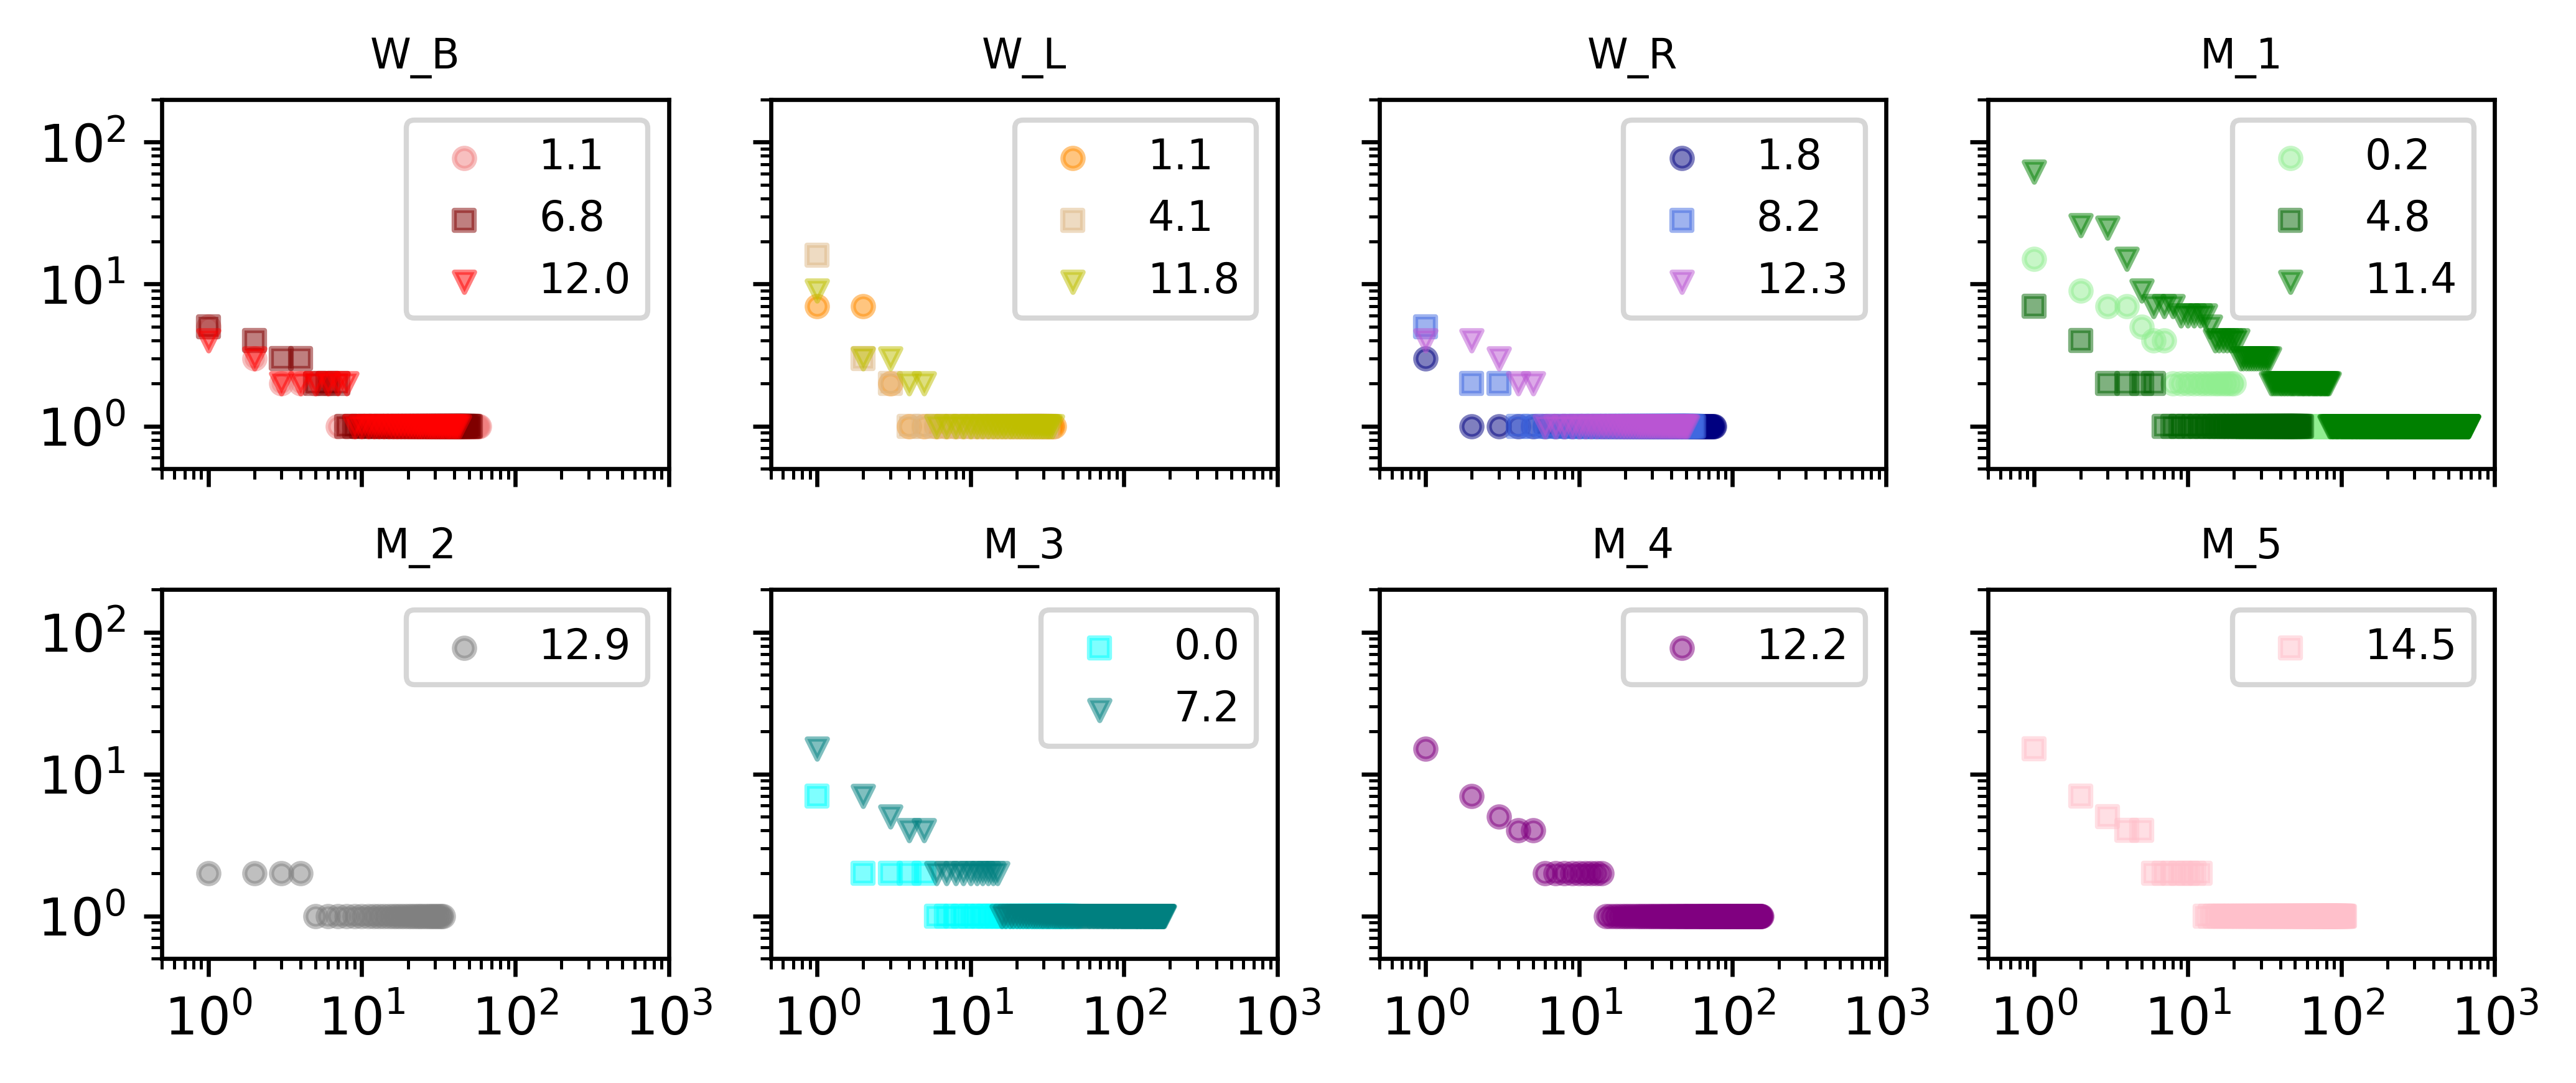

In [30]:
#rank abundance plots for each ppt
fig,axarr=plt.subplots(2,4,sharex=True,sharey=True,dpi=600,figsize=(7,3))
name='+'
ppt_ind=-1
for i in range(len(obz)):

    if obz[i].name[2]!=name:
        pl_t=[[],[]]
        ppt_ind+=1
        name=obz[i].name[2]
        
    ax=axarr[int(ppt_ind/4)][ppt_ind%4]
    
    ss=ax.scatter(range(1,len(obz[i].abundance)+1),obz[i].abundance,color=obz[i].c,marker=obz[i].m,s=15,alpha=0.5)
    #ss=ax.scatter(range(1,len(obz[i].abundance)+1),100*obz[i].abundance/sum(obz[i].abundance),color=obz[i].c,marker=obz[i].m,s=15,alpha=0.8)
    pl_t[0].append(ss)
    pl_t[1].append(obz[i].t)
    
    ax.loglog()
    ax.set_title(obz[i].name[:3],fontsize=8)
    ax.legend(pl_t[0],pl_t[1],fontsize=8,loc=1)
    
ax.set_xlim([0.5,1e3])
ax.set_ylim([5e-1,200])
plt.tight_layout()
plt.savefig('figures/WM_ra.pdf')

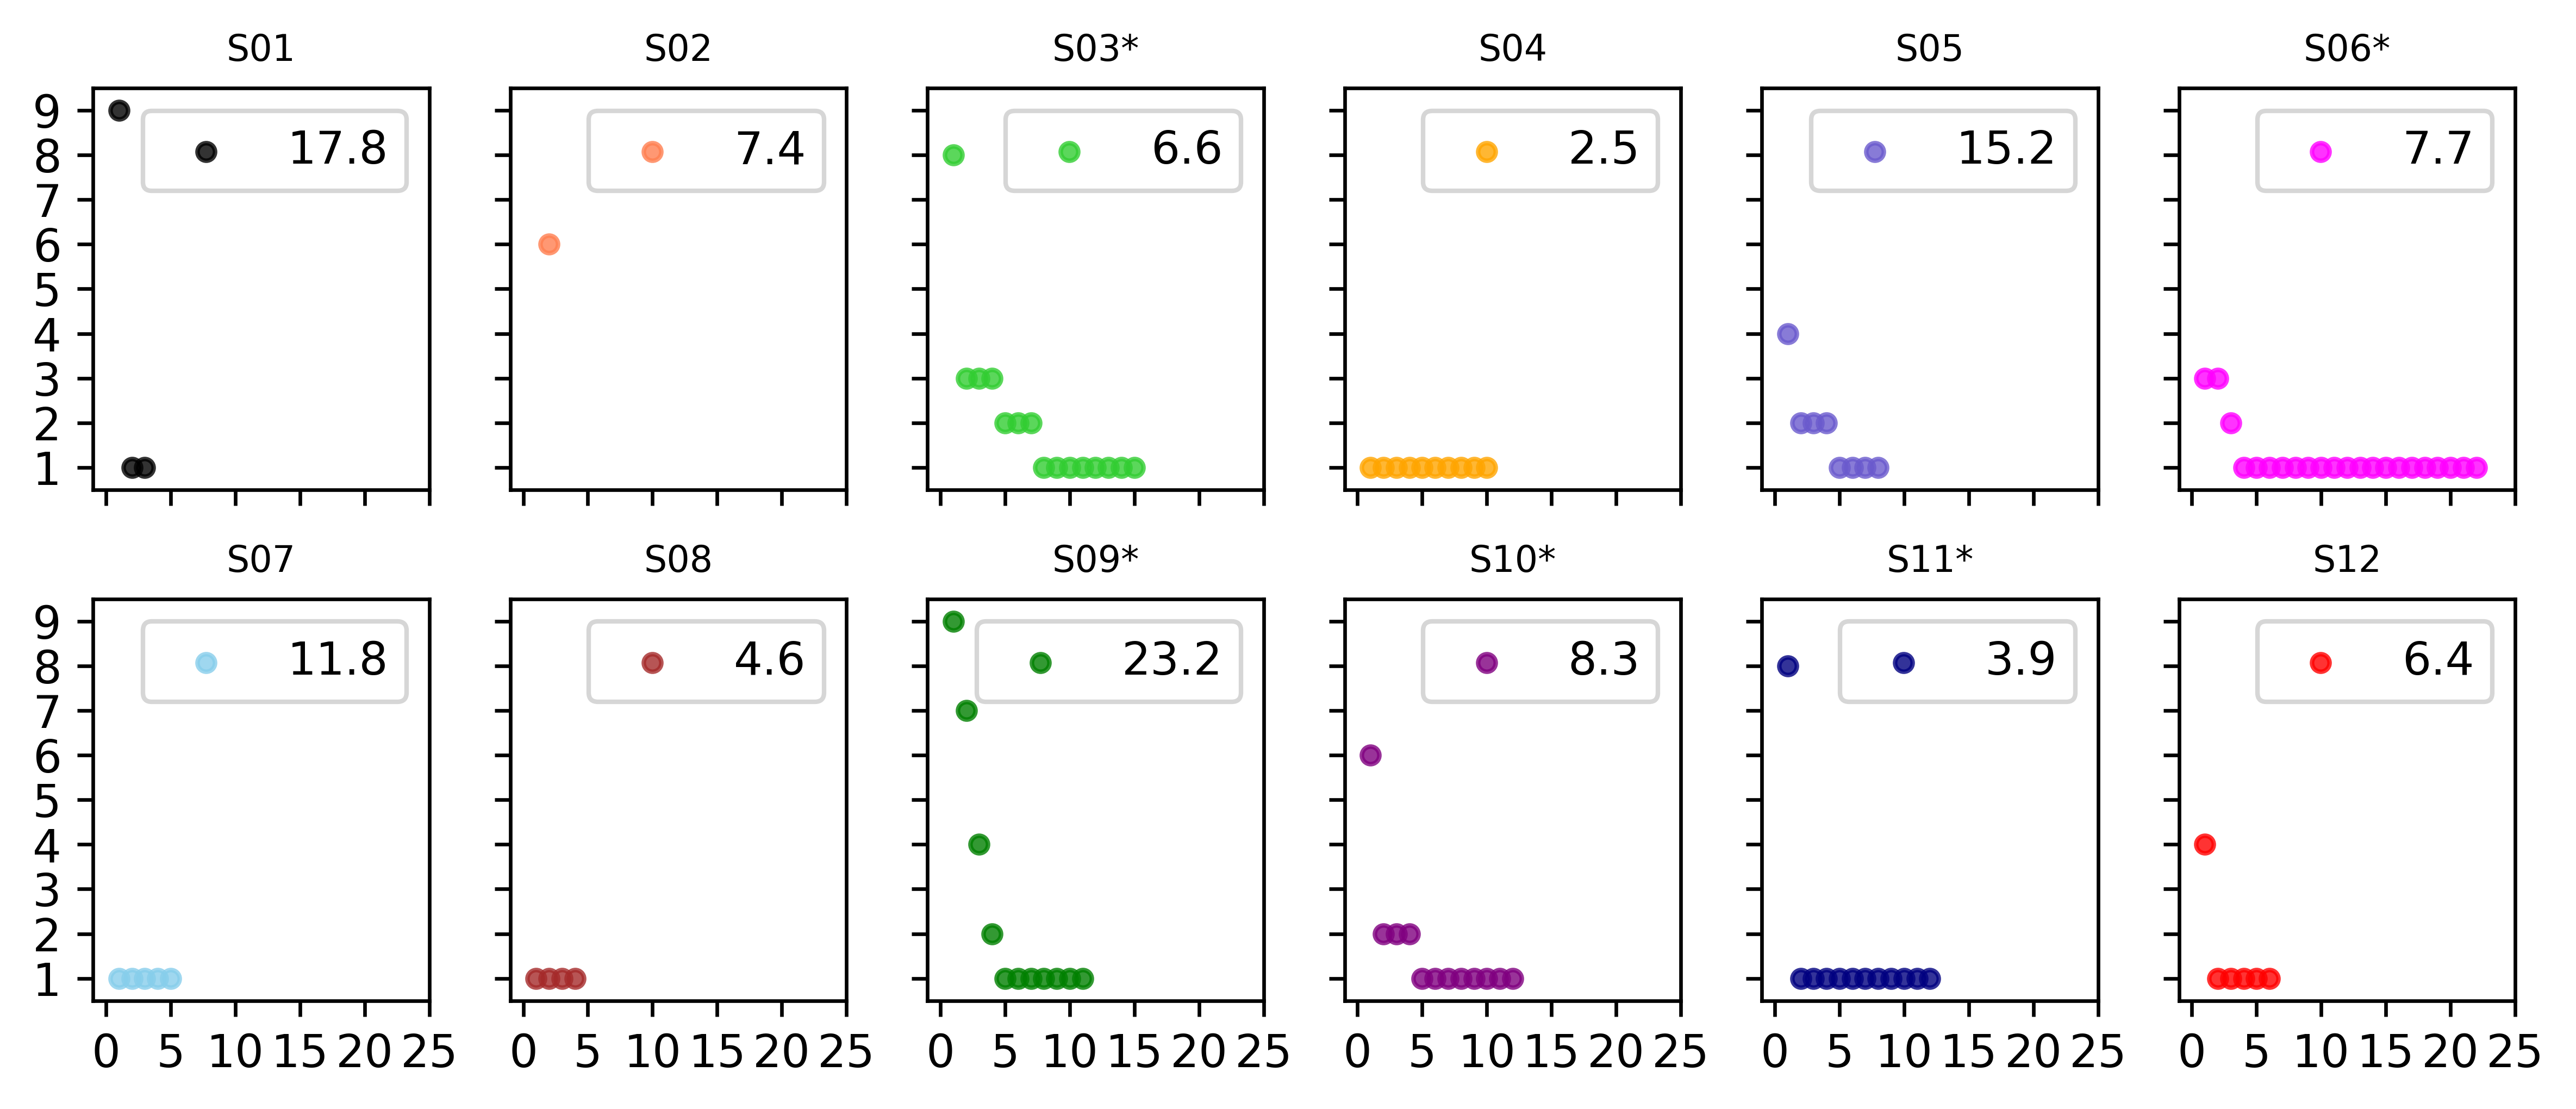

In [37]:
#rank abundance for Hosmane
S01=[9,1,1]
S02=[6,11]
S03=[8,3,2,1,2,1,2,1,1,3,1,1,1,1,3]
S04=[1,1,1,1,1,1,1,1,1,1]
S05=[2,1,1,2,4,1,2,1]
S06=[3,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,3,1,1,1,1]
S07=[1,1,1,1,1]
S08=[1,1,1,1]
S09=[7,1,1,1,1,1,4,1,1,2,9]
S10=[6,1,1,1,1,2,2,1,1,2,1,1]
S11=[8,1,1,1,1,1,1,1,1,1,1,1]
S12=[4,1,1,1,1,1]

art_time=[17.8,7.4,6.6,2.5,15.2,7.7,11.8,4.6,23.2,8.3,3.9,6.4] #years of ART

S=[S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12] 
Snz=['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12'] #names
Hcz=['black','coral','limegreen','orange','slateblue','magenta','skyblue','brown','green','purple','navy','red']

ok_list=[2,5,8,9,10] #list with number of samples>20
#ok_list=[0,2,4,5,8,9,10,11] #list with more than 2 ranks and more than only singlets

fig,axarr=plt.subplots(2,6,sharex=True,sharey=True,dpi=600,figsize=(8,3.5))
#fig,axarr=plt.subplots(1,5,sharex=True,sharey=True,dpi=600,figsize=(7,2))
for i in range(len(S)):
#for i in range(len(ok_list)):
        
    #ax=axarr[i]
    ax=axarr[int(i/6)][i%6]
    
    abund=np.flipud(np.sort(S[i]))
    #abund=np.flipud(np.sort(S[ok_list[i]]))
    ranks=np.arange(1,len(abund)+1)
    
    ax.scatter(ranks,abund,color=Hcz[i],marker='o',s=15,alpha=0.8)
    ax.legend([str(art_time[i])],fontsize=10)
    
    #ax.loglog()
    if i in ok_list:
        titz=Snz[i]+'*'
    else:
        titz=Snz[i]
    ax.set_title(titz,fontsize=8)

ax.set_xlim([-1,25])
ax.set_ylim([0.5,9.5])
ax.set_xticks(range(0,26,5))
ax.set_yticks(range(1,10))
plt.tight_layout()
plt.savefig('figures/H_ra.pdf')

In [27]:
#print some sentences about the data
num_clones=[]
frac_clones=[]
frac_cells_in_clones=[]
cells_in_clones=[]
cells_in_max_clone=[]
frac_in_max_clone=[]
for i in range(len(obz)):
    ob=obz[i]
    num_clones.append(sum(obz[i].Nx[2:]))
    frac_clones.append(sum(obz[i].Nx[2:])/sum(obz[i].Nx))
    
    NS=obz[i].Nx*np.arange(len(obz[i].Nx)) #number of cells N(n)*n
    cells_in_clones.append(sum(NS[2:])) #observed sequence clones
    frac_cells_in_clones.append(sum(NS[2:])/obz[i].N) #observed sequence clones
    cells_in_max_clone.append(NS[-1])
    frac_in_max_clone.append(NS[-1]/ob.N)
    
def printer(x):
    print(np.min(x),'-',np.max(x),'mean: ', np.mean(x))
    
print('HIV DNA')
print('number of observed sequences that were clonal')
printer(num_clones)
print('fraction of observed sequences that were clonal')
printer(frac_clones)
#print('number of cells observed from clonal populations')
#printer(cells_in_clones)
#print('fraction of cells observed from clonal populations')
#printer(frac_cells_in_clones)
print('number of cells observed in the largest clone')
printer(cells_in_max_clone)
print('fraction of cells observed in the largest clone')
printer(frac_in_max_clone)

num_clones=[]
frac_clones=[]
for i in range(len(S)):
            
    abund=np.flipud(np.sort(S[i]))
    ranks=np.arange(1,len(abund)+1)
    
    num_clones.append(sum(abund>1)) #number of clonal types
    frac_clones.append(sum(abund>1)/sum(abund)) #fraction clonal of all types

print('REPLICATION COMPETENT (all)')
print('fraction of observed sequences that were clonal')
printer(frac_clones)

num_clones=[]
frac_clones=[]
frac_cells_in_clones=[]
cells_in_clones=[]
cells_in_max_clone=[]
frac_in_max_clone=[]
for i in range(len(ok_list)):
            
    abund=np.flipud(np.sort(S[ok_list[i]]))
    ranks=np.arange(1,len(abund)+1)
    
    cells_in_max_clone.append(abund[0])
    frac_in_max_clone.append(abund[0]/sum(abund))
    
    num_clones.append(sum(abund>1)) #number of clonal types
    frac_clones.append(sum(abund>1)/sum(abund)) #fraction clonal of all types
    
print('REPLICATION COMPETENT (N>20)')
print('number of cells observed in the largest clone')
printer(cells_in_max_clone)
print('fraction of cells observed in the largest clone')
printer(frac_in_max_clone)
print('number of observed sequences that were clonal')
printer(num_clones)


HIV DNA
number of observed sequences that were clonal
1 - 83 mean:  11.7647058824
fraction of observed sequences that were clonal
0.0131578947368 - 0.186046511628 mean:  0.103469024
number of cells observed in the largest clone
3 - 62 mean:  12.5294117647
fraction of cells observed in the largest clone
0.0384615384615 - 0.32 mean:  0.122685421917
REPLICATION COMPETENT (all)
fraction of observed sequences that were clonal
0.0 - 0.285714285714 mean:  0.111071810226
REPLICATION COMPETENT (N>20)
number of cells observed in the largest clone
3 - 9 mean:  6.8
fraction of cells observed in the largest clone
0.111111111111 - 0.421052631579 mean:  0.280114617281
number of observed sequences that were clonal
1 - 7 mean:  3.8


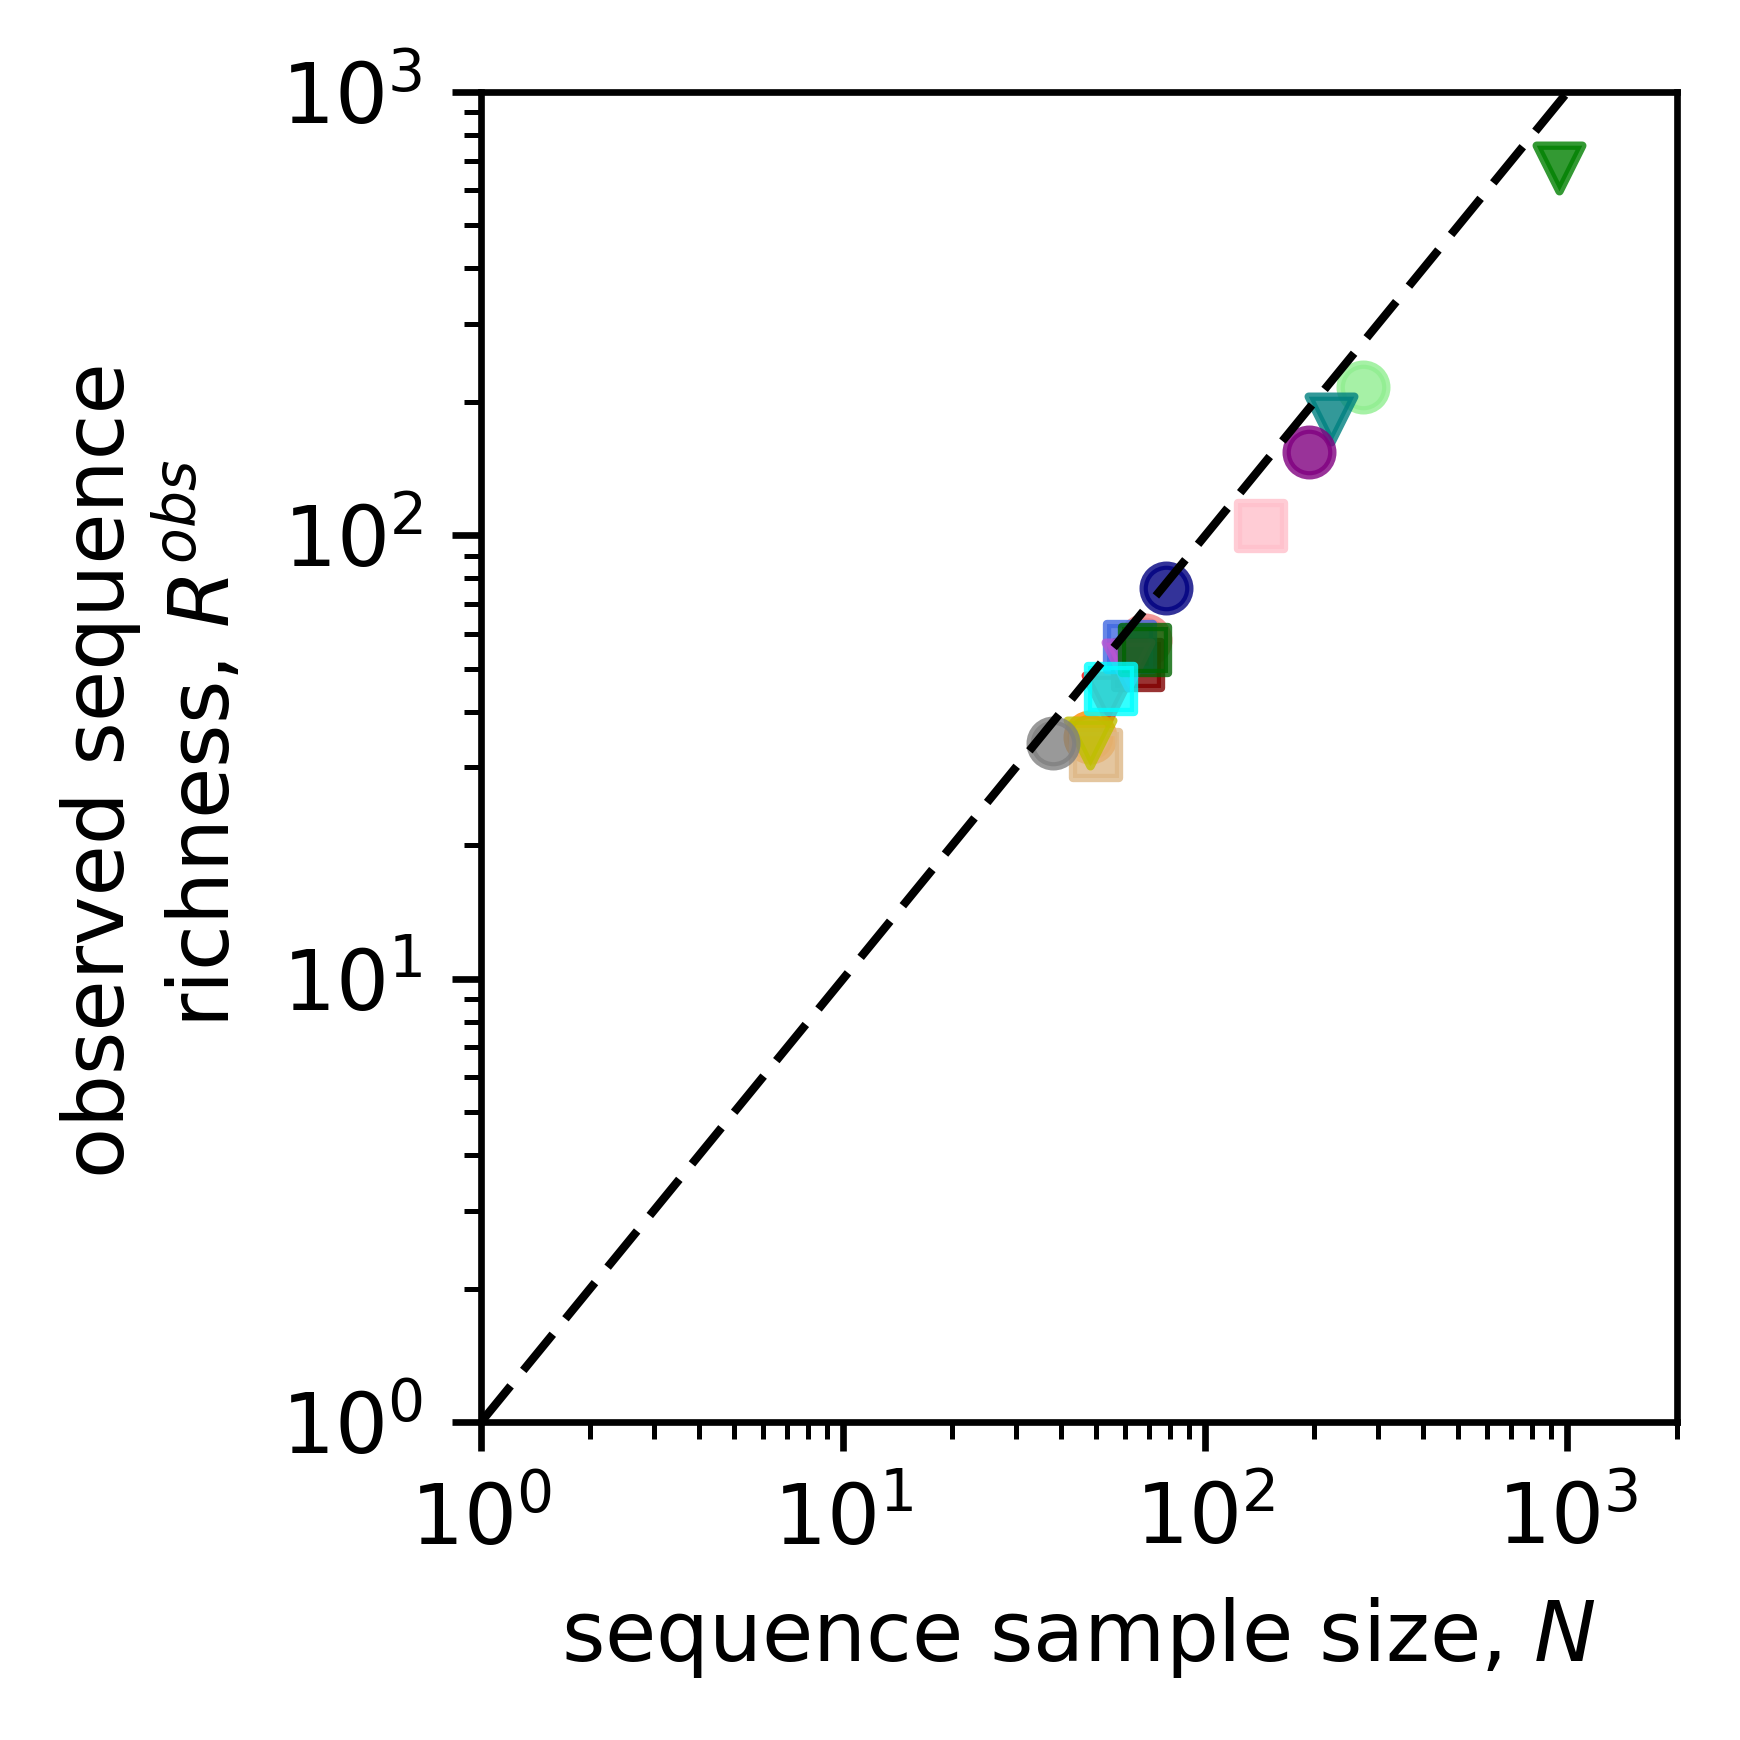

In [28]:
#plot “HIV sequence sample size (N)” (x-axis) versus “Number of distinct sequences (N(1)+2N(2)+3n(3)+….) (y-axis)

#samples plotted out, most have <50
plt.figure(figsize=(3,3),dpi=600)
xtz=[]
for i in range(len(obz)):
    plt.scatter(obz[i].N,obz[i].Robs,color=obz[i].c,marker=obz[i].m,s=30,alpha=0.8)
    xtz.append(obz[i].name)

plt.loglog(np.arange(1e4),np.arange(1e4),ls='--',color='k',lw=1)
plt.xlabel('sequence sample size, $N$')
plt.ylabel('observed sequence \n richness, $R^{obs}$')
#plt.yticks(range(len(obz)),xtz,rotation=0,fontsize=10)
plt.ylim([1,1e3])
plt.xlim([1,2e3])
#plt.title('WM')
#plt.ylim([-1,len(obz)])

plt.tight_layout()
plt.savefig('figures/WM_NvR.pdf')

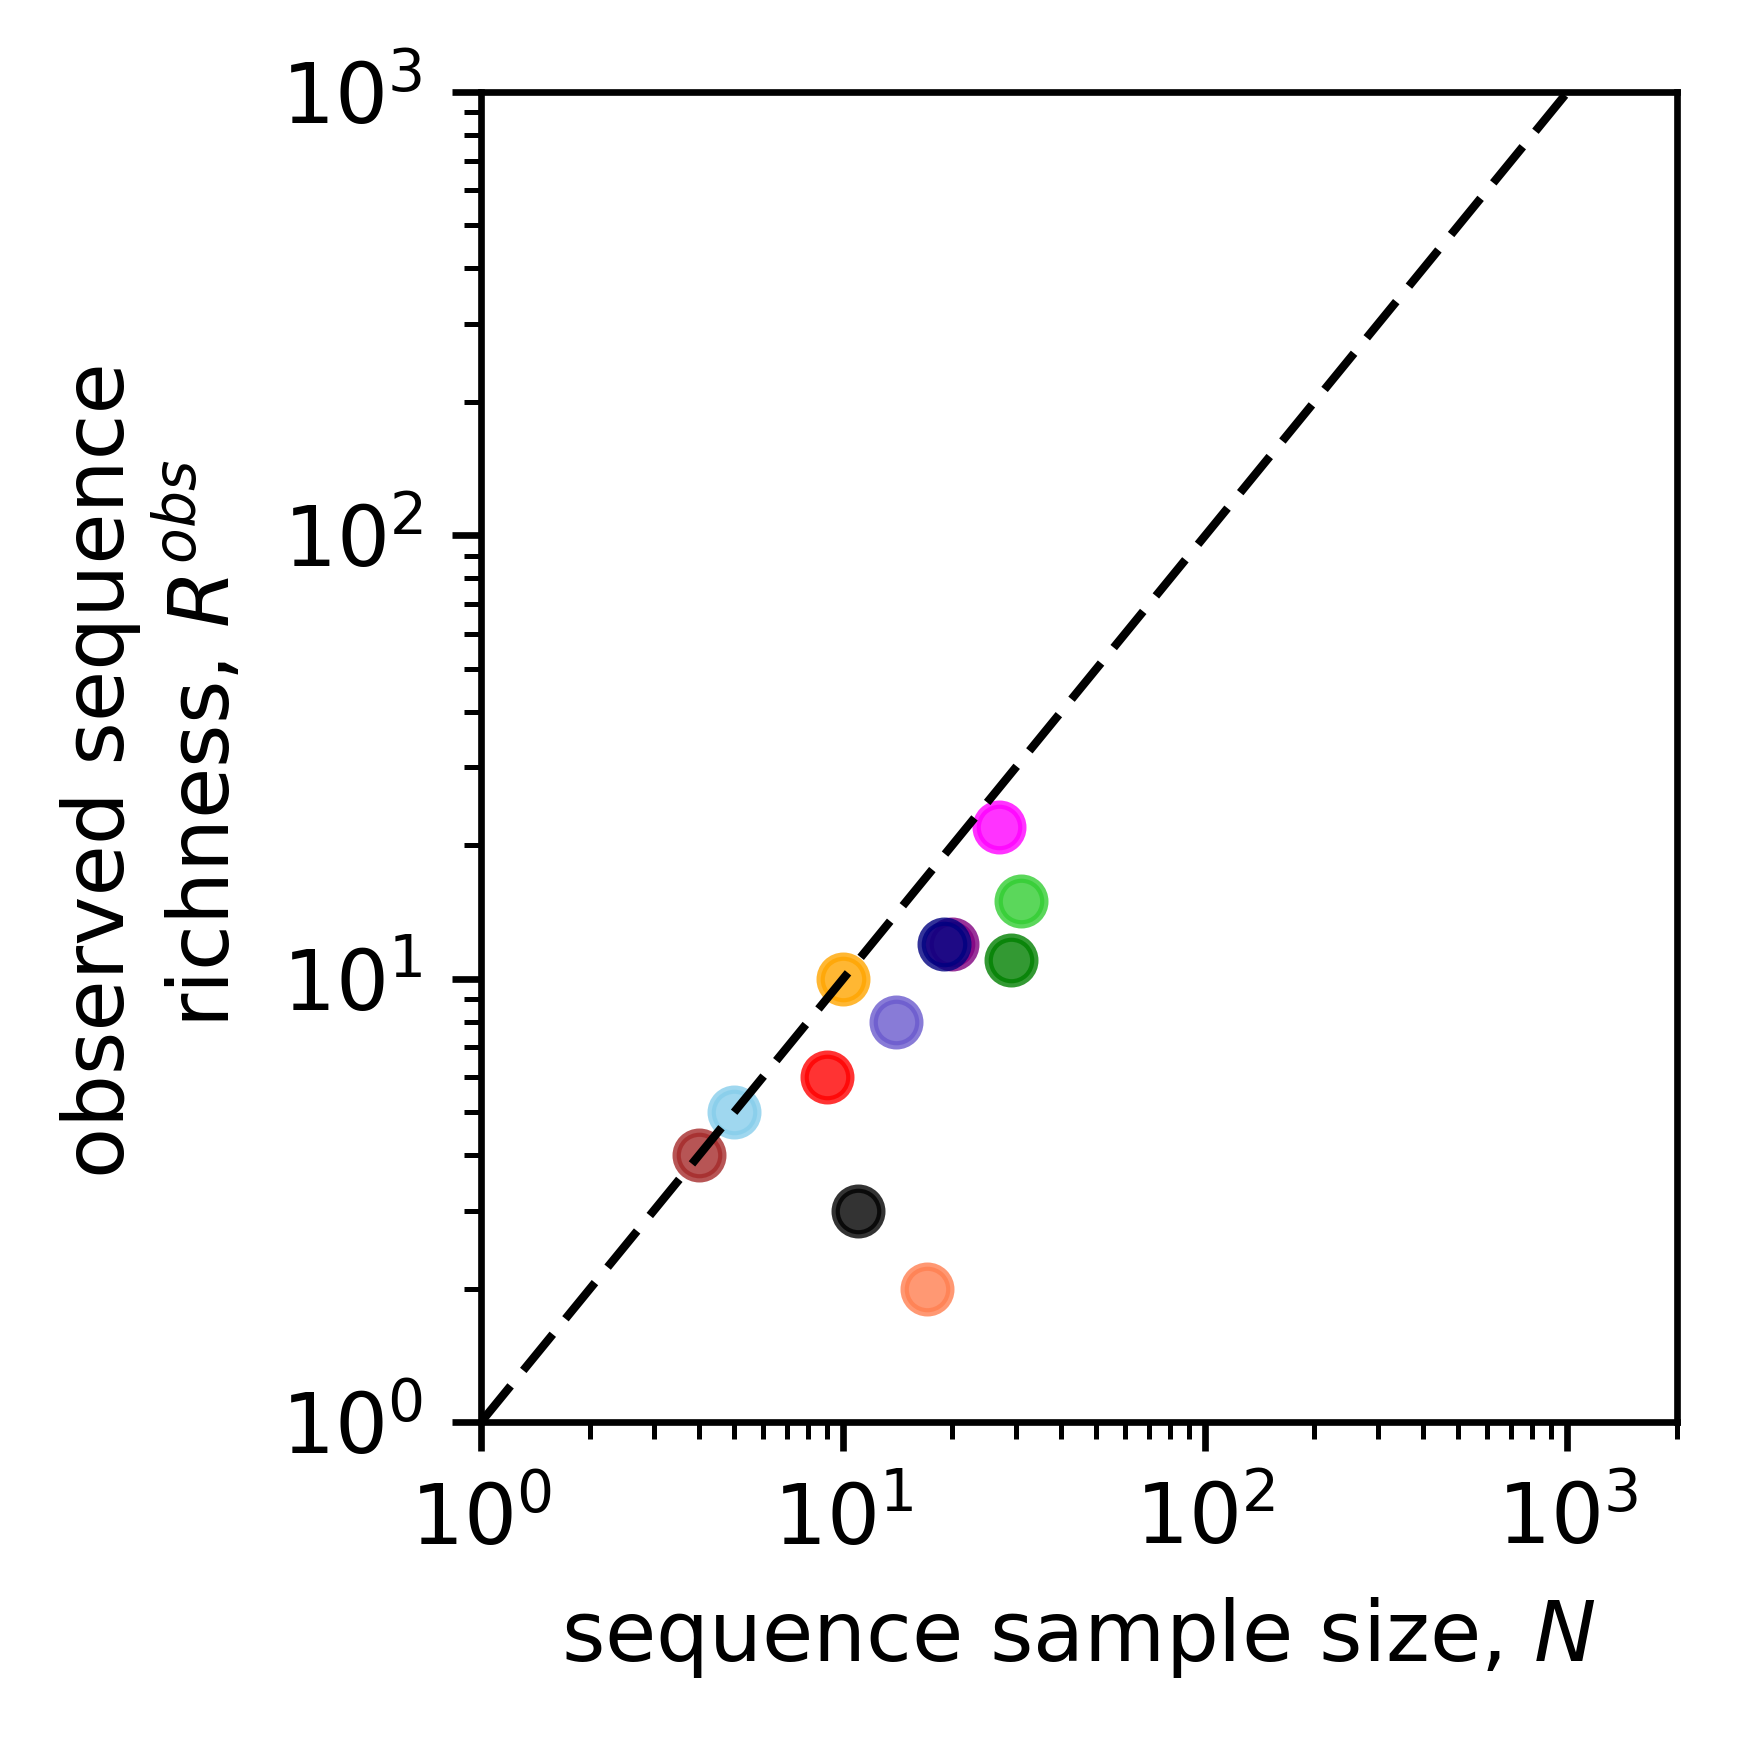

In [31]:
#plot HOSMANE “HIV sequence sample size (N)” (x-axis) versus “Number of distinct sequences (N(1)+2N(2)+3n(3)+….) (y-axis)

#samples plotted out, most have <50
plt.figure(figsize=(3,3),dpi=600)
xtz=[]
#for i in range(len(ok_list)):    
#    abund=np.flipud(np.sort(S[ok_list[i]]))
for i in range(len(S)):
    abund=np.flipud(np.sort(S[i]))
    plt.scatter(sum(abund),len(abund),color=Hcz[i],s=30,alpha=0.8)

plt.loglog(np.arange(1e3),np.arange(1e3),ls='--',color='k',lw=1)
plt.xlabel('sequence sample size, $N$')
plt.ylabel('observed sequence \n richness, $R^{obs}$')
#plt.yticks(range(len(obz)),xtz,rotation=0,fontsize=10)
plt.ylim([1,1e3])
plt.xlim([1,2e3])

plt.tight_layout()
plt.savefig('figures/H_NvR.pdf')

In [34]:
#rarefaction calculation
def rarefact(rank,abundance,num_samples):
    R=max(rank); L=sum(abundance)
    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        ss=[]
        for j in range(len(abundance)):
            ss.append(sp.misc.comb(L-abundance[j],n))
        r_list[n-1]=(R - sum(ss)/sp.misc.comb(L,n))    
    return n_list,r_list

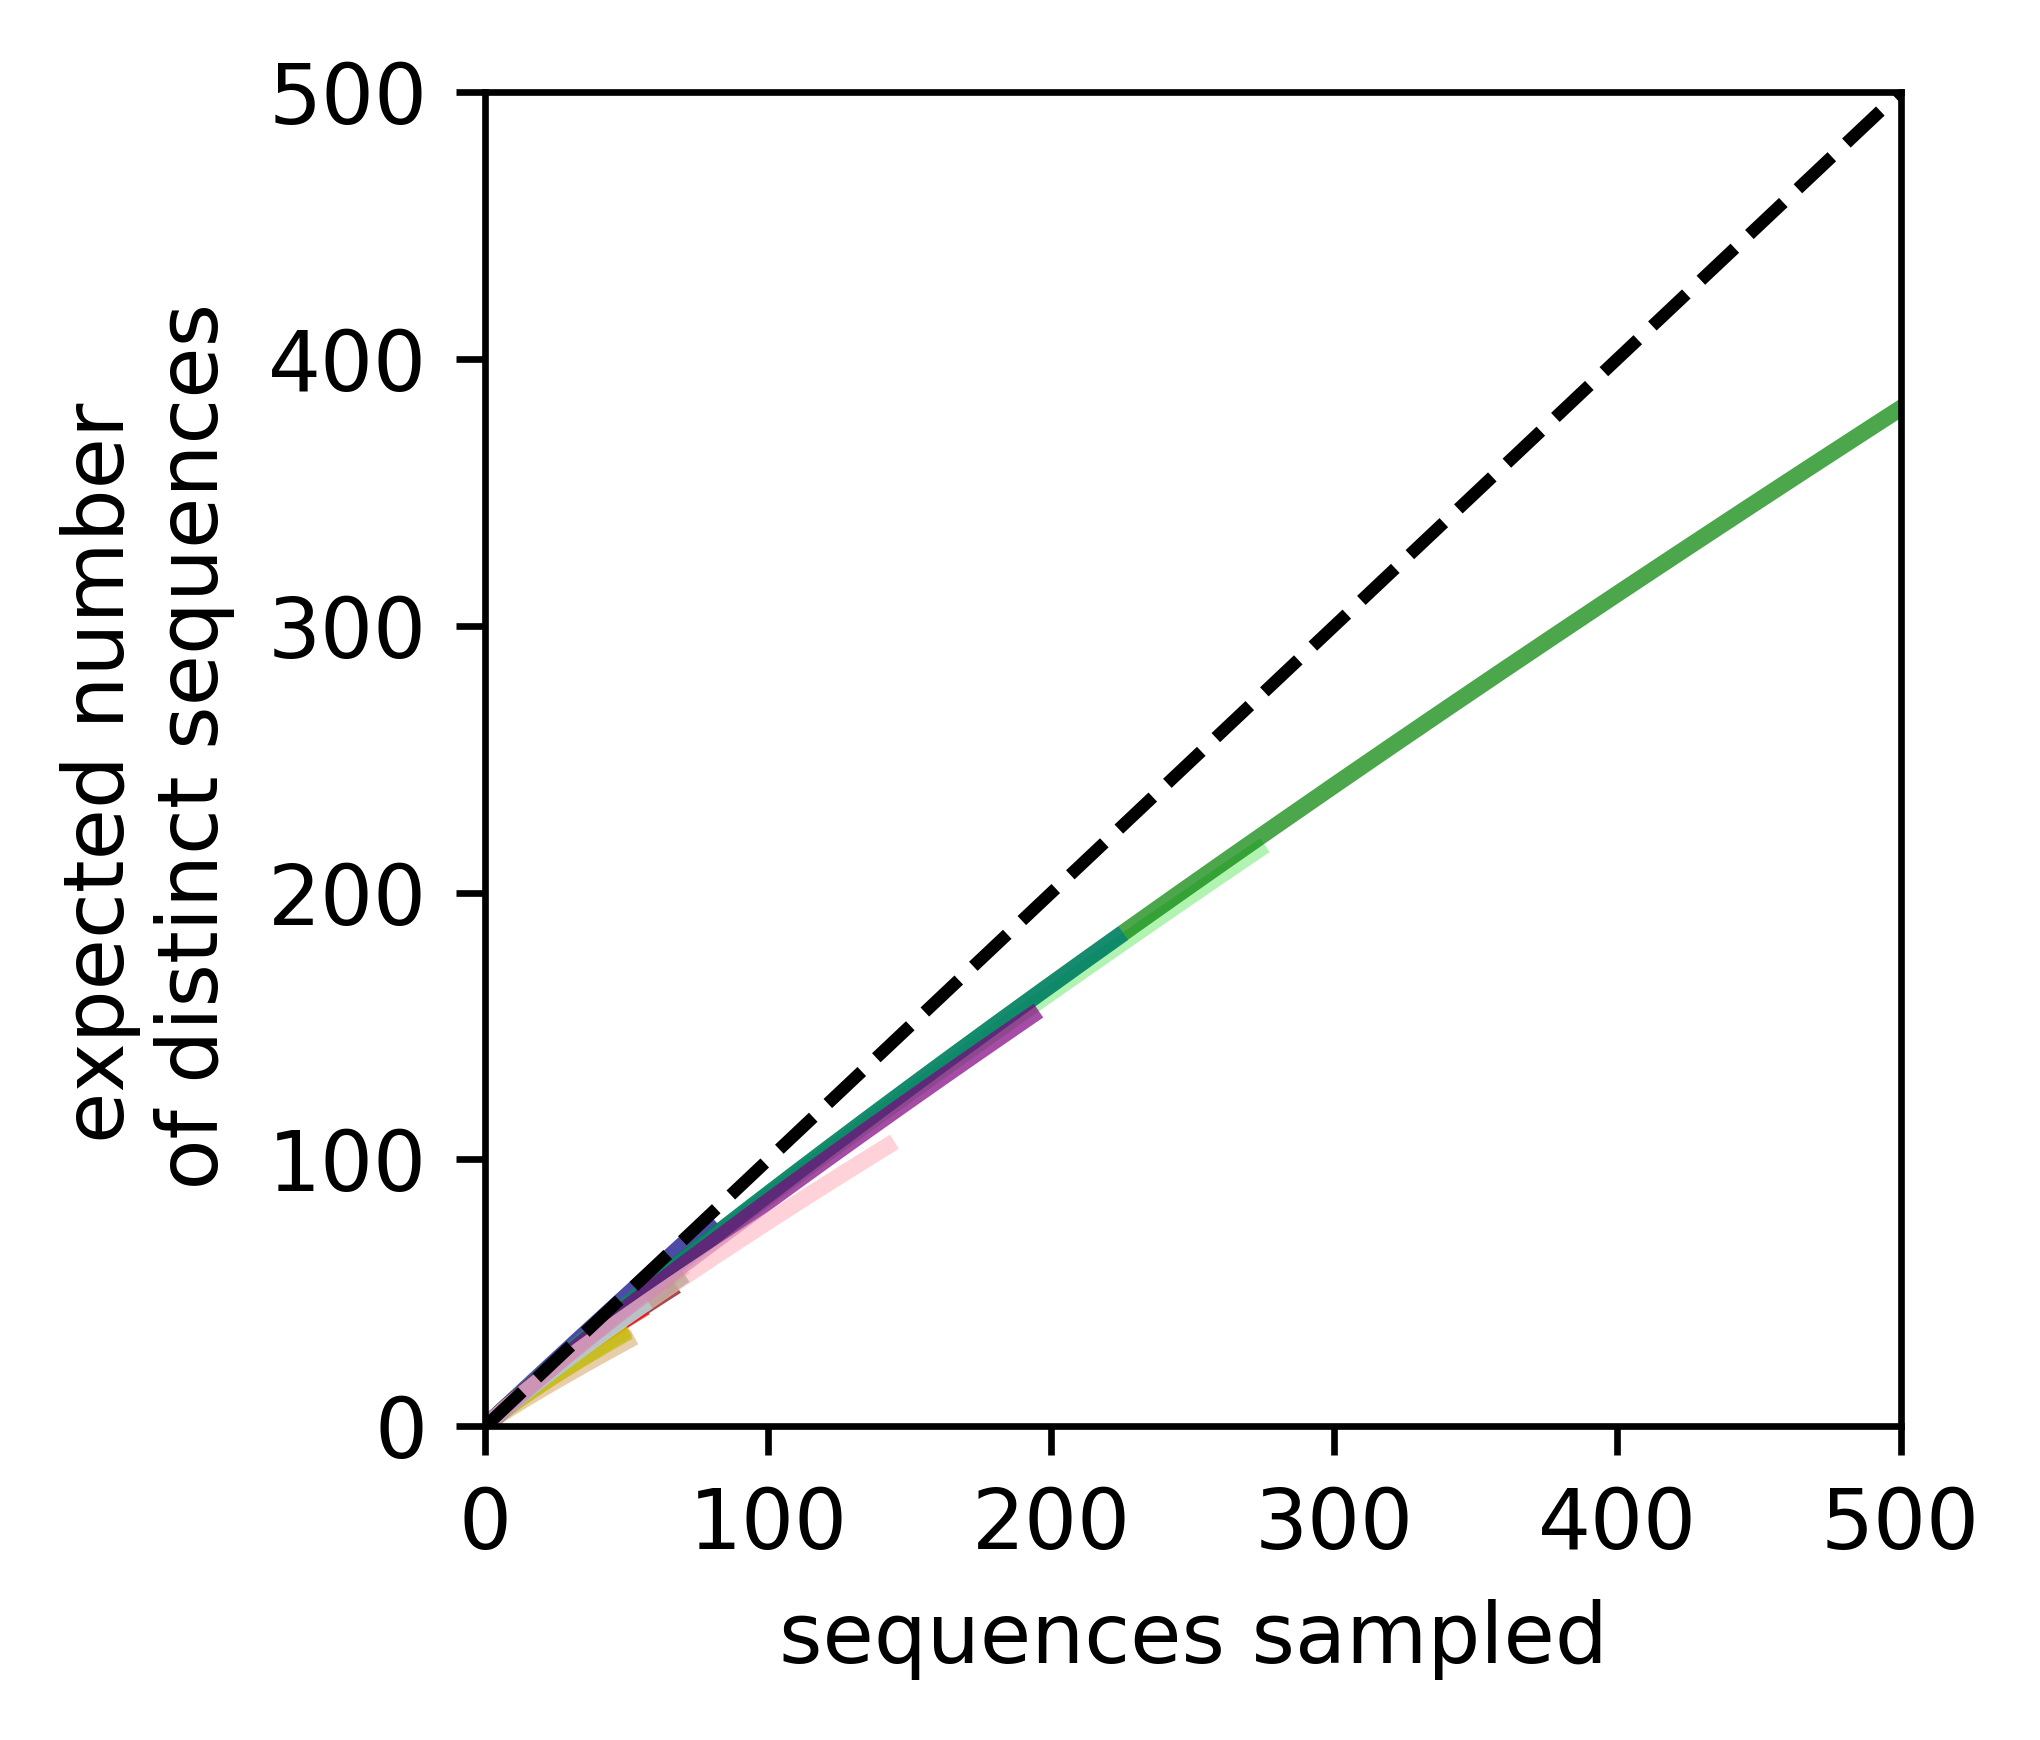

In [35]:
#observed rarefaction for WM
plt.figure(figsize=(3.5,3),dpi=rez)
for i in range(len(obz)):
    #compute each experimental rarefaction curve
    ranks=np.arange(len(obz[i].abundance))+1
    data_nrare,data_Rrare = rarefact(ranks,obz[i].abundance,num_samples=int(obz[i].N))       
    #data_nrare,data_Rrare = rarefaction_approx(ranks,obz[i].abundance,num_samples=int(obz[i].N))       
    plt.plot(data_nrare,data_Rrare,color=obz[i].c,lw=2,alpha=0.7)
#plt.xlabel('number of samples collected')
#plt.ylabel('expected number of \n distinct strains (observed)')
plt.xlim([0,500])
plt.ylim([0,500])
plt.plot(np.linspace(1,1e3,5),np.linspace(1,1e3,5),ls='--',color='black')
plt.tight_layout()
plt.xlabel('sequences sampled')
plt.ylabel('expected number \n of distinct sequences')
plt.tight_layout()
plt.savefig('figures/WM_rarefact.pdf')   



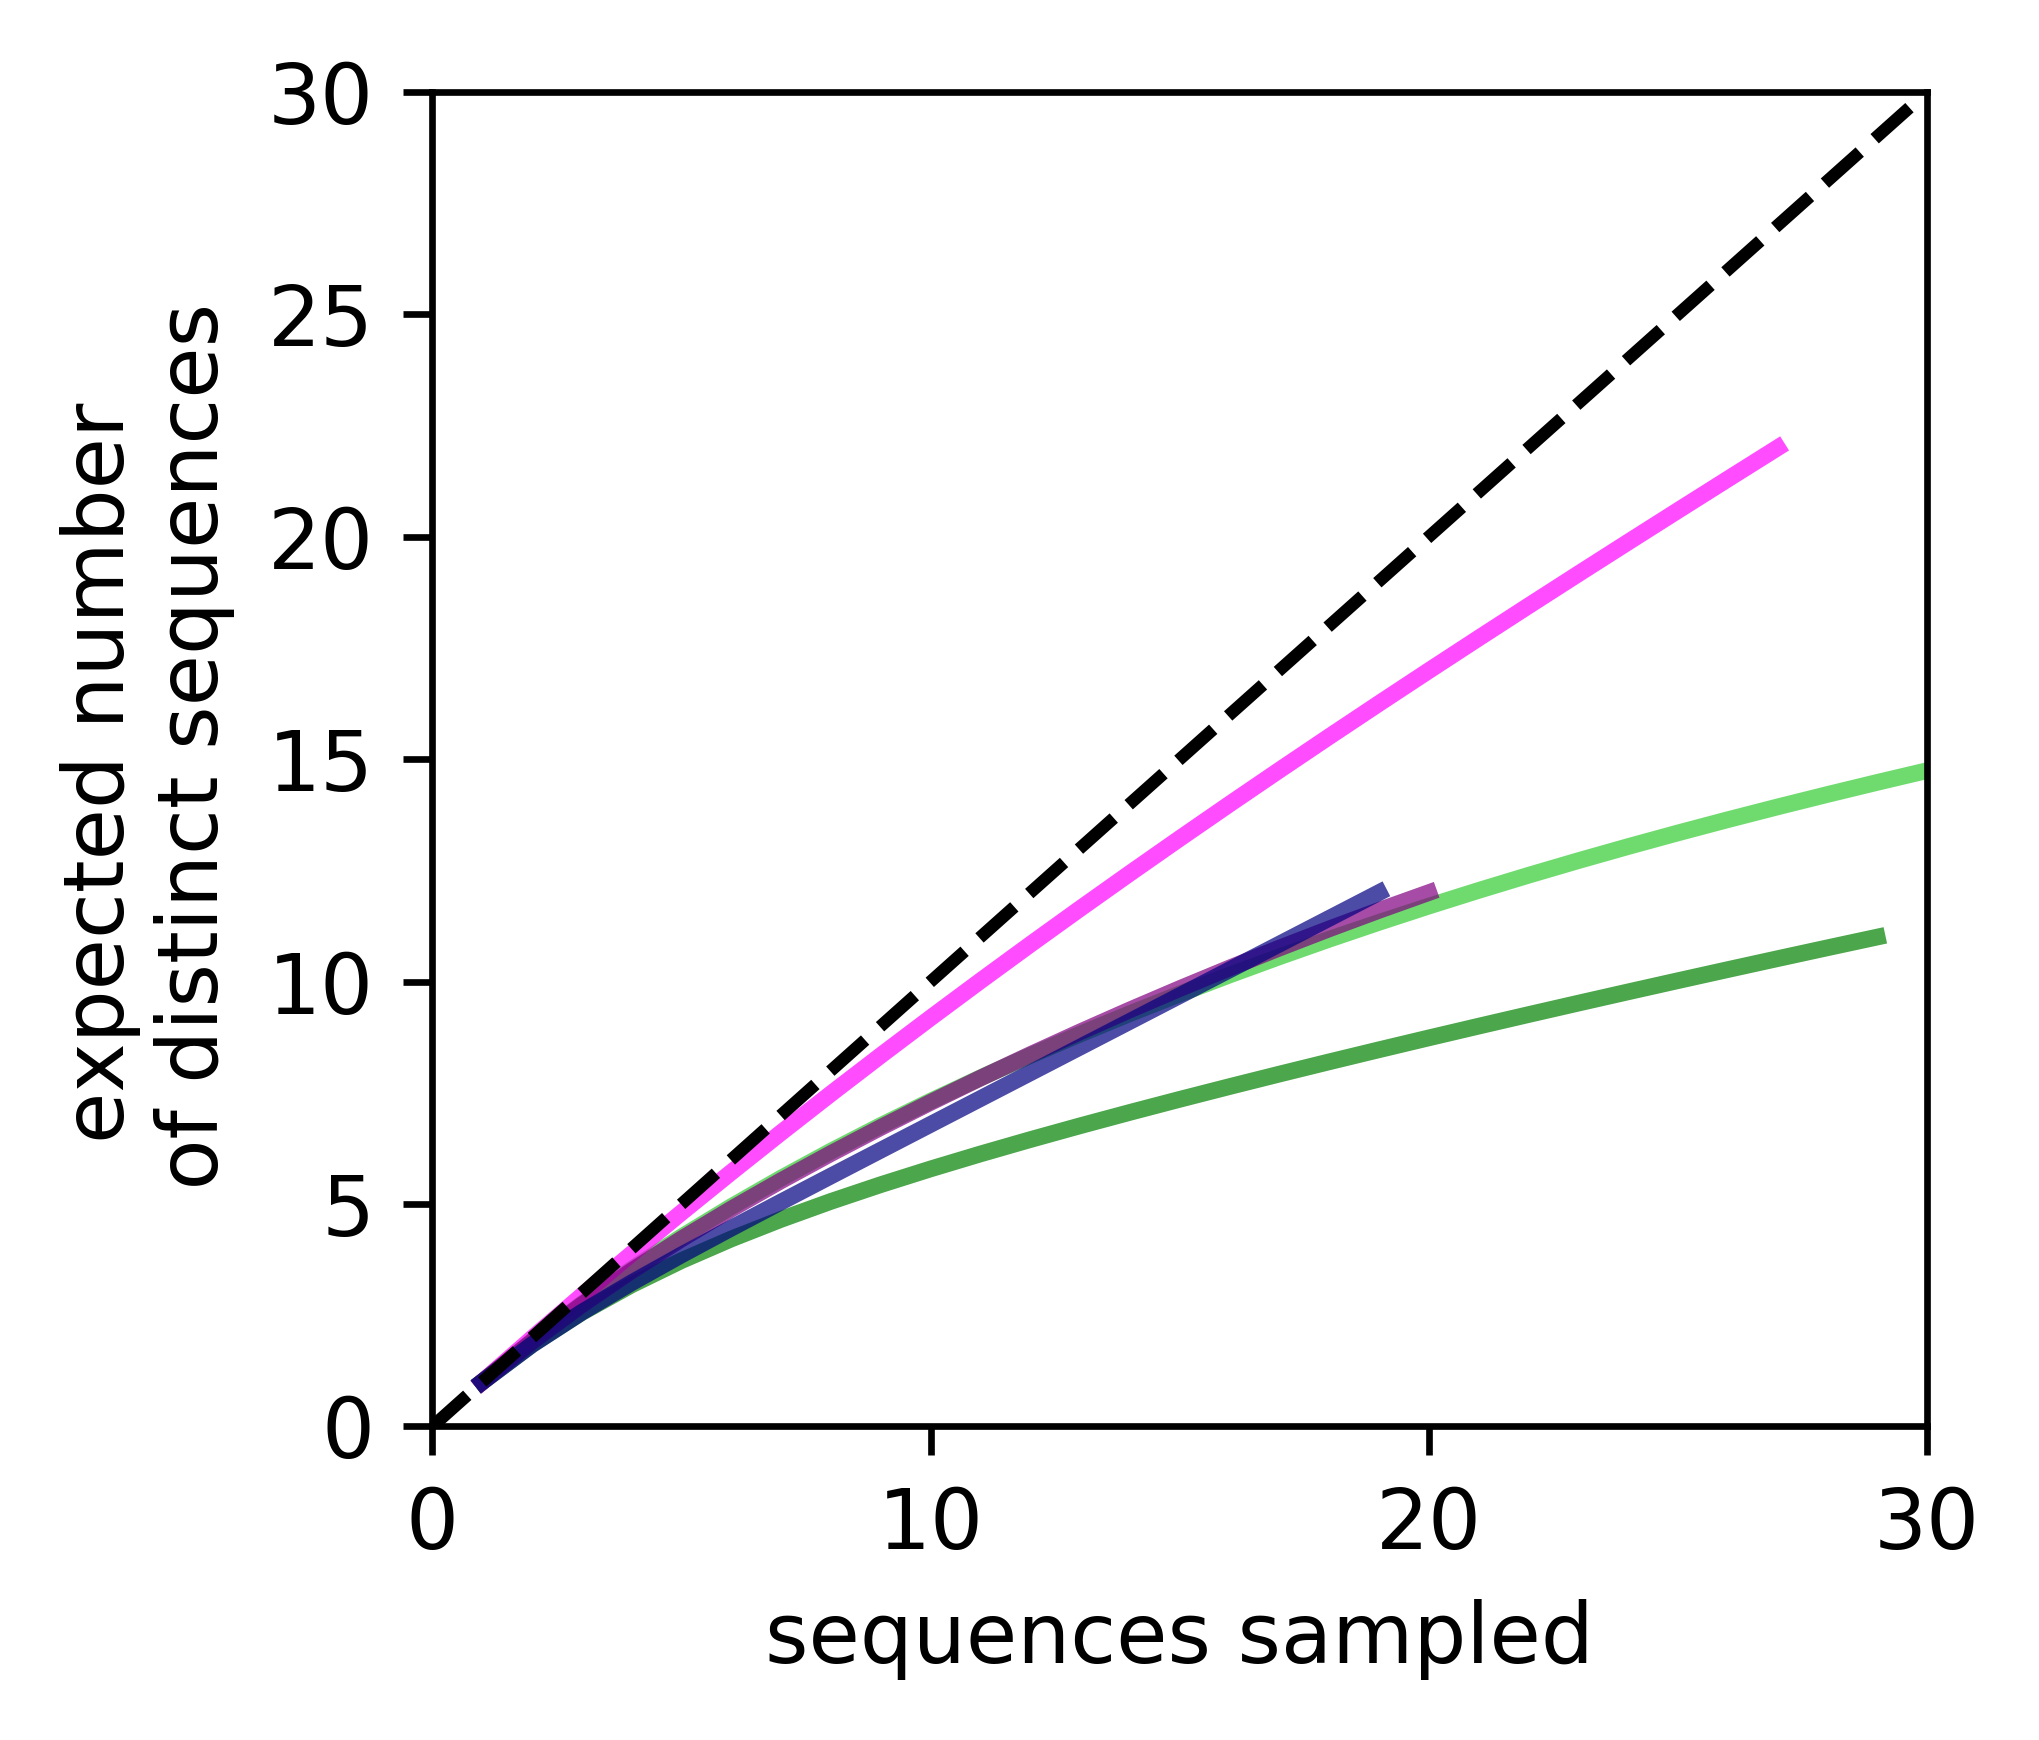

In [36]:
#observed rarefaction for HOSMANE
plt.figure(figsize=(3.5,3),dpi=rez)
#compute each experimental rarefaction curve
for i in range(len(ok_list)):    
    abund=np.flipud(np.sort(S[ok_list[i]]))
    ranks=np.arange(1,len(abund)+1)
    data_nrare,data_Rrare = rarefact(ranks,abund,num_samples=int(sum(abund)))       
    #data_nrare,data_Rrare = rarefaction_approx(ranks,obz[i].abundance,num_samples=int(obz[i].N))       
    plt.plot(data_nrare,data_Rrare,color=Hcz[ok_list[i]],lw=2,alpha=0.7)
#plt.xlabel('number of samples collected')
#plt.ylabel('expected number of \n distinct strains (observed)')
plt.xlim([0,30])
plt.ylim([0,30])
plt.plot(np.linspace(0,1e2,5),np.linspace(0,1e2,5),ls='--',color='black')
plt.tight_layout()
plt.xlabel('sequences sampled')
plt.ylabel('expected number \n of distinct sequences')
plt.tight_layout()
plt.savefig('figures/H_rarefact.pdf')   



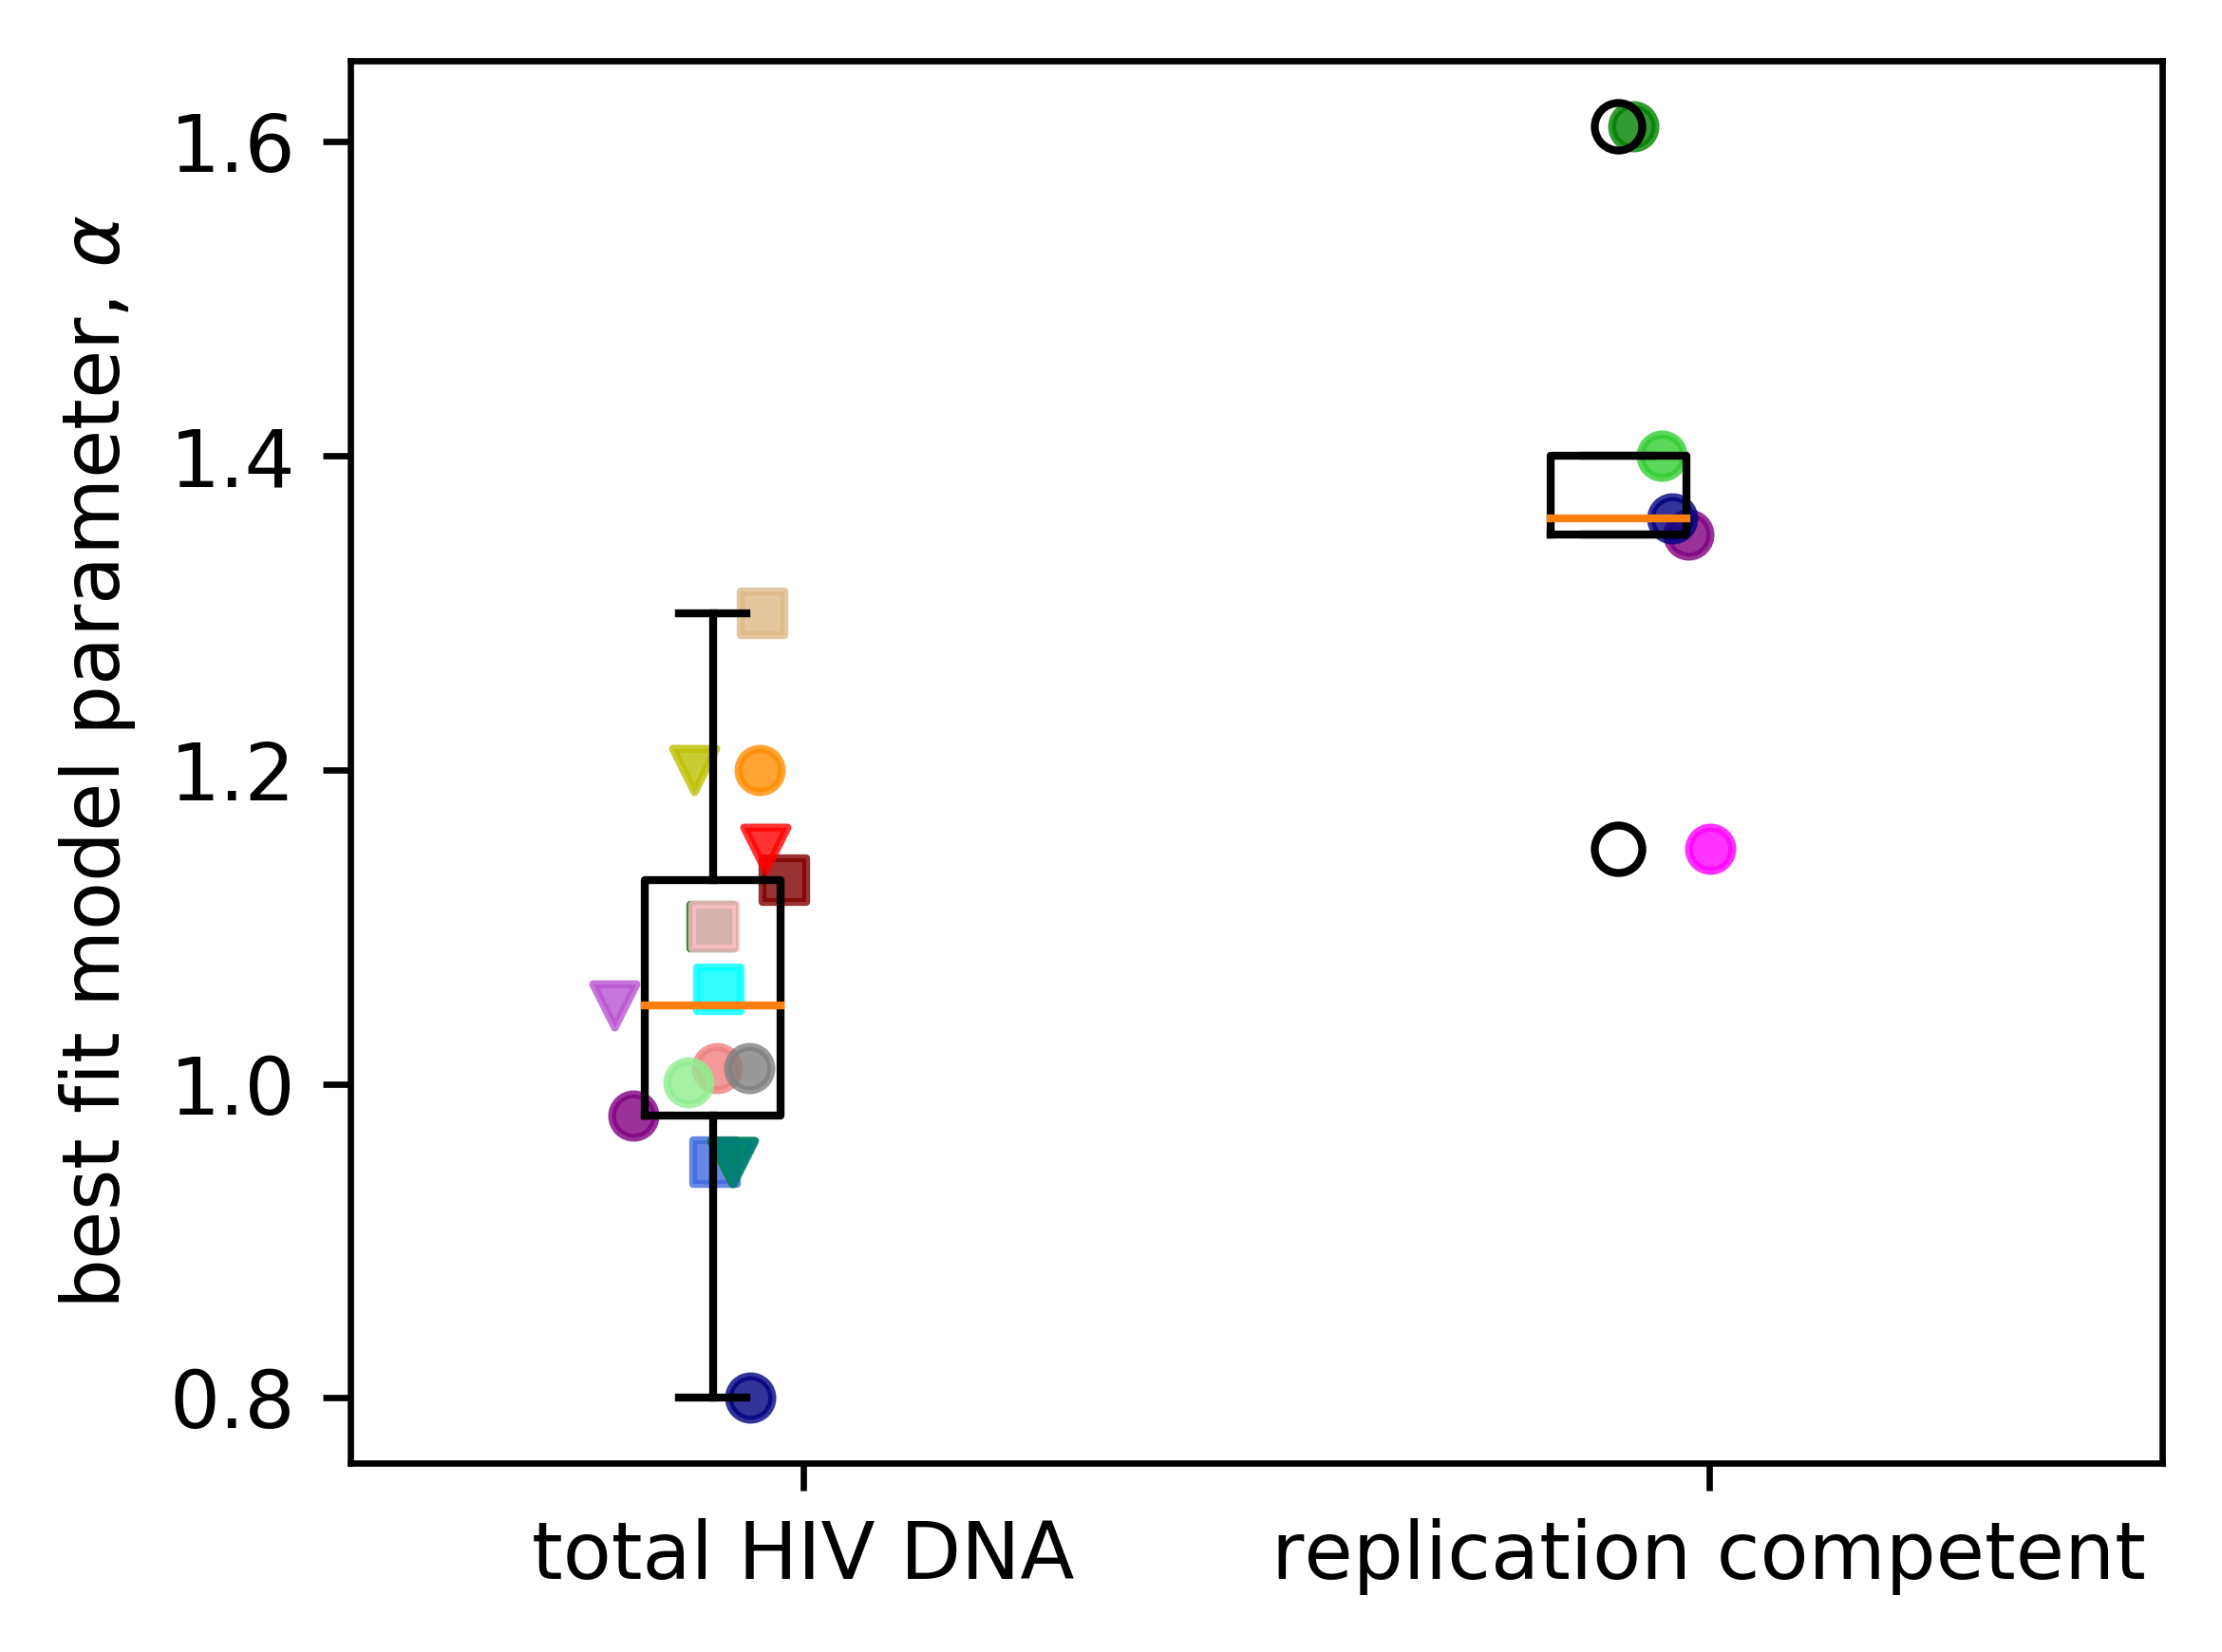

In [50]:
#showing max richness based on best fit alphas

best_al_Hos=[1.4,1.15,1.61,1.35,1.36]   
best_al_DNA=[1.01,1.13,1.15,
                1.2,1.3,1.2,
                0.8,0.95,1.05,
                1.001,1.1,0.95,
                1.01,
                1.06,0.95,
                0.98,
                1.1]
    
plt.figure(figsize=(4,3),dpi=600)
for i in range(len(obz)):
    al=best_al_DNA[i]
    ob=obz[i]
    plt.scatter(np.random.normal(1,0.05),best_al_DNA[i],color=ob.c,marker=ob.m,s=30,alpha=0.8)

for i in range(len(ok_list)):    
    plt.scatter(np.random.normal(2,0.05),best_al_Hos[i],color=Hcz[ok_list[i]],s=30,alpha=0.8)

plt.boxplot([best_al_DNA,best_al_Hos])
plt.xlim([0.6,2.6])
plt.xticks([1.1,2.1],['total HIV DNA','replication competent'])
plt.ylabel(r'best fit model parameter, $\alpha$')
plt.tight_layout()
plt.savefig('figures/alphas.pdf')

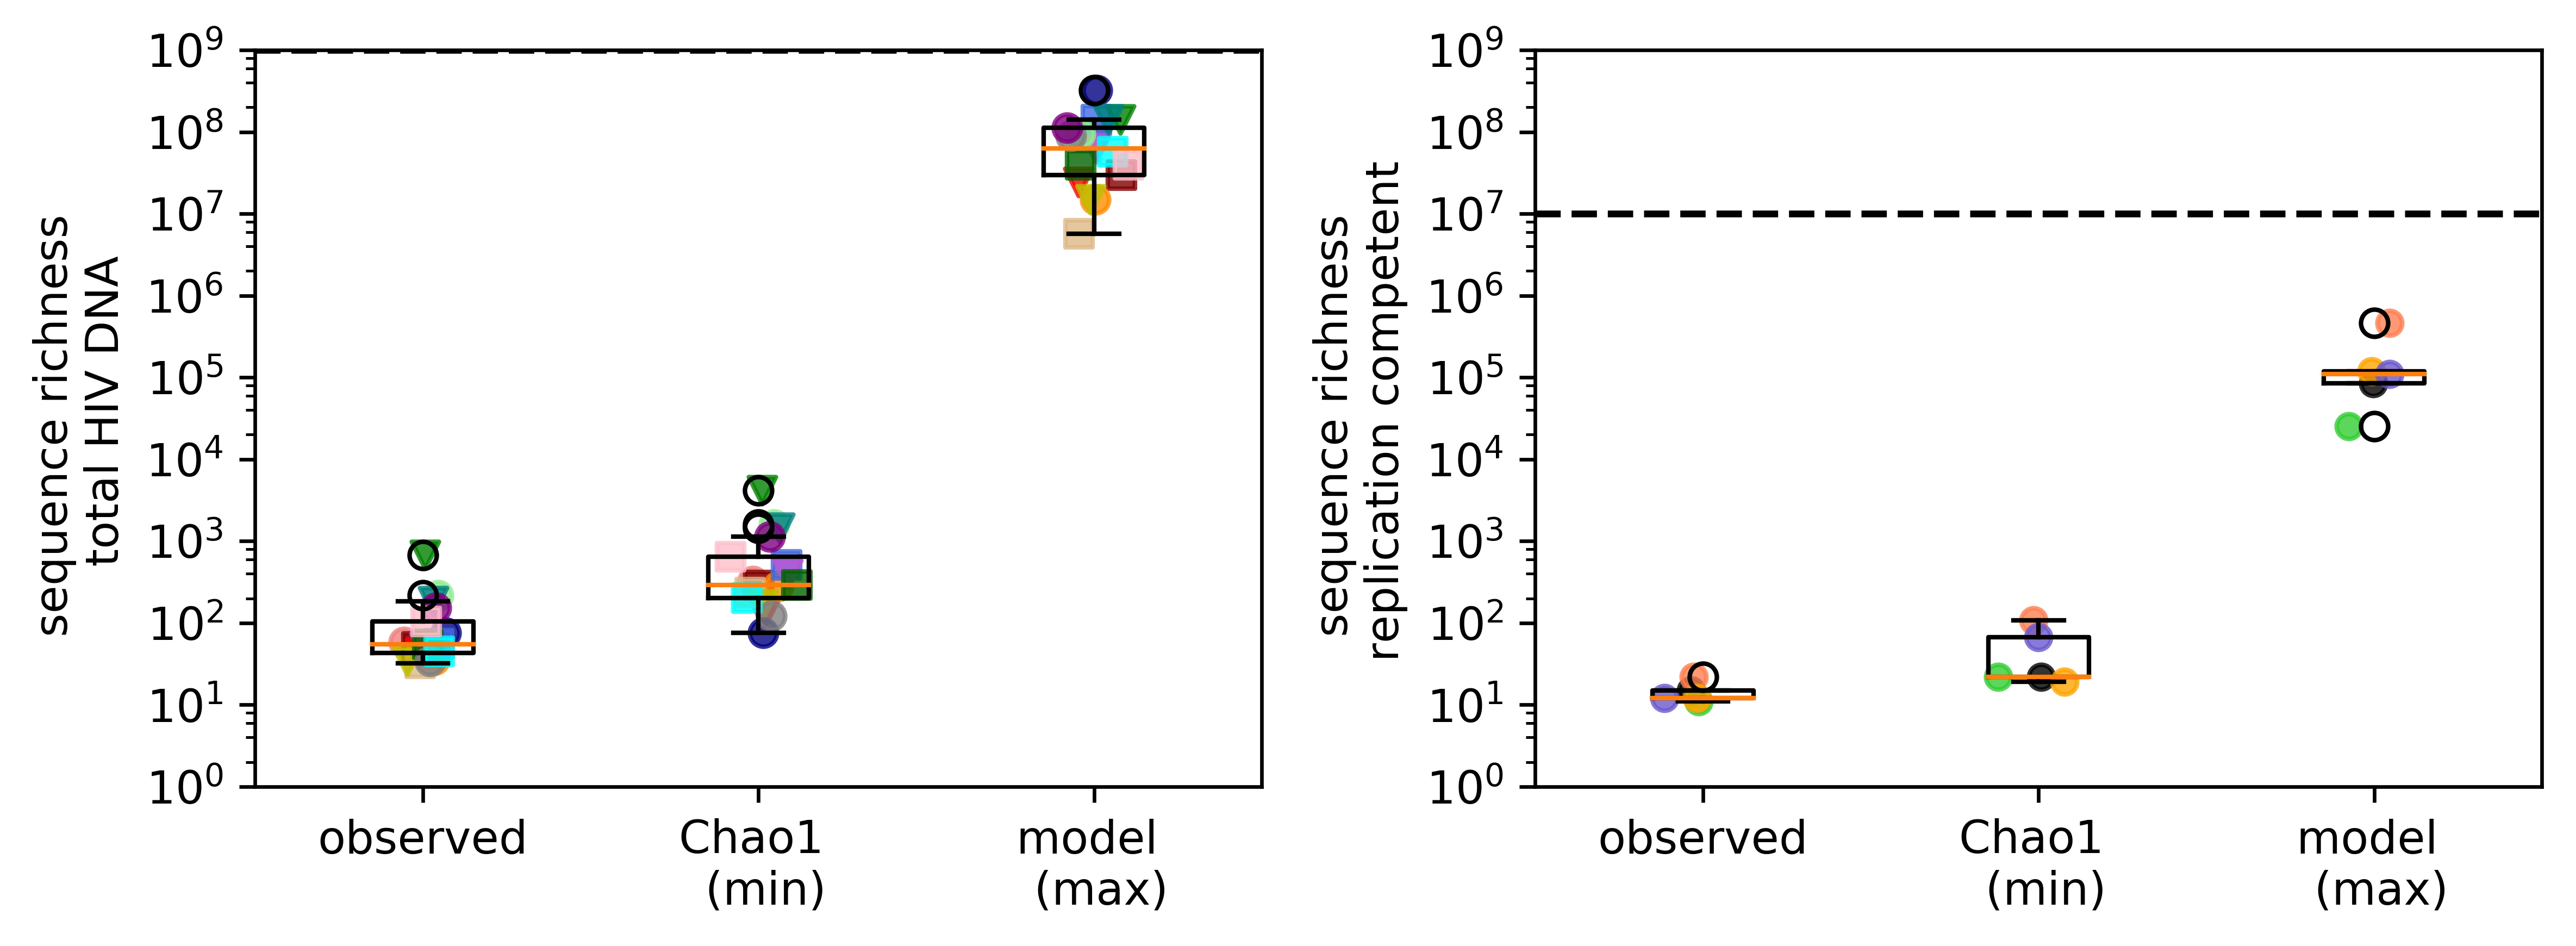

In [45]:
#compare richness estimates

#plot richness and estimates all as boxplots
plt.figure(figsize=(8,3),dpi=rez)

#lists for richness estimates
RlWM=[[],[],[]]; RWM=1e9; LWM=1e9
RlH=[[],[],[]]; RH=1e7; LH=1e7

plt.subplot(121)
for i in range(len(obz)):
           
    al=best_al_DNA[i]    
    psi=0.5*(1-RWM**(1-al))/(LWM*(al-1));
    mr=np.exp(np.log(psi)/-al); #approximate max richness
    if mr>RWM:
        mr=RWM

    plt.scatter(np.random.normal(1,0.05),obz[i].Robs,color=obz[i].c,marker=obz[i].m,alpha=0.8)
    plt.scatter(np.random.normal(2,0.05),obz[i].Rchao,color=obz[i].c,marker=obz[i].m,alpha=0.8)
    plt.scatter(np.random.normal(3,0.05),mr,color=obz[i].c,marker=obz[i].m,alpha=0.8)

    RlWM[0].append(obz[i].Robs)
    RlWM[1].append(obz[i].Rchao)
    RlWM[2].append(mr)

plt.boxplot(RlWM)
plt.ylabel('sequence richness \n total HIV DNA') 
plt.yscale('log')  
plt.xticks([1,2,3],['observed','Chao1 \n (min)','model \n (max)'])
plt.ylim([1,1e9])
plt.axhline(LWM,color='k',ls='--')
plt.yticks(np.logspace(0,9,10))

plt.subplot(122)
for i in range(len(ok_list)):    
    abund=np.flipud(np.sort(S[ok_list[i]]))
    
    Robs=len(abund)
    plt.scatter(np.random.normal(1,0.05),Robs,color=Hcz[i],s=30,alpha=0.8)
    
    RlH[0].append(Robs)
    
    f1=sum(abund==1)
    f2=sum(abund==2)
            
    Rchao = np.round(Robs + f1*(f1-1)/(2*(f2+1)))
    plt.scatter(np.random.normal(2,0.05),Rchao,color=Hcz[i],s=30,alpha=0.8)

    RlH[1].append(Rchao)
   
    al=best_al_Hos[i]
    psi=0.5*(1-RH**(1-al))/(LH*(al-1));
    mr=np.exp(np.log(psi)/-al); #approximate max richness
    if mr>RH:
        mr=RH
    RlH[2].append(mr)
    plt.scatter(np.random.normal(3,0.05),mr,color=Hcz[i],s=30,alpha=0.8)

plt.boxplot(RlH)
plt.ylabel('sequence richness \n replication competent') 
plt.yscale('log')  
plt.xticks([1,2,3],['observed','Chao1 \n (min)','model \n (max)'])
plt.ylim([1,1e9])
plt.axhline(LH,color='k',ls='--')
plt.yticks(np.logspace(0,9,10))

plt.tight_layout()
plt.savefig('figures/richness.pdf')


7.00008789231
7.00200225215
6.99999570046
7.00017129539
7.00015071746


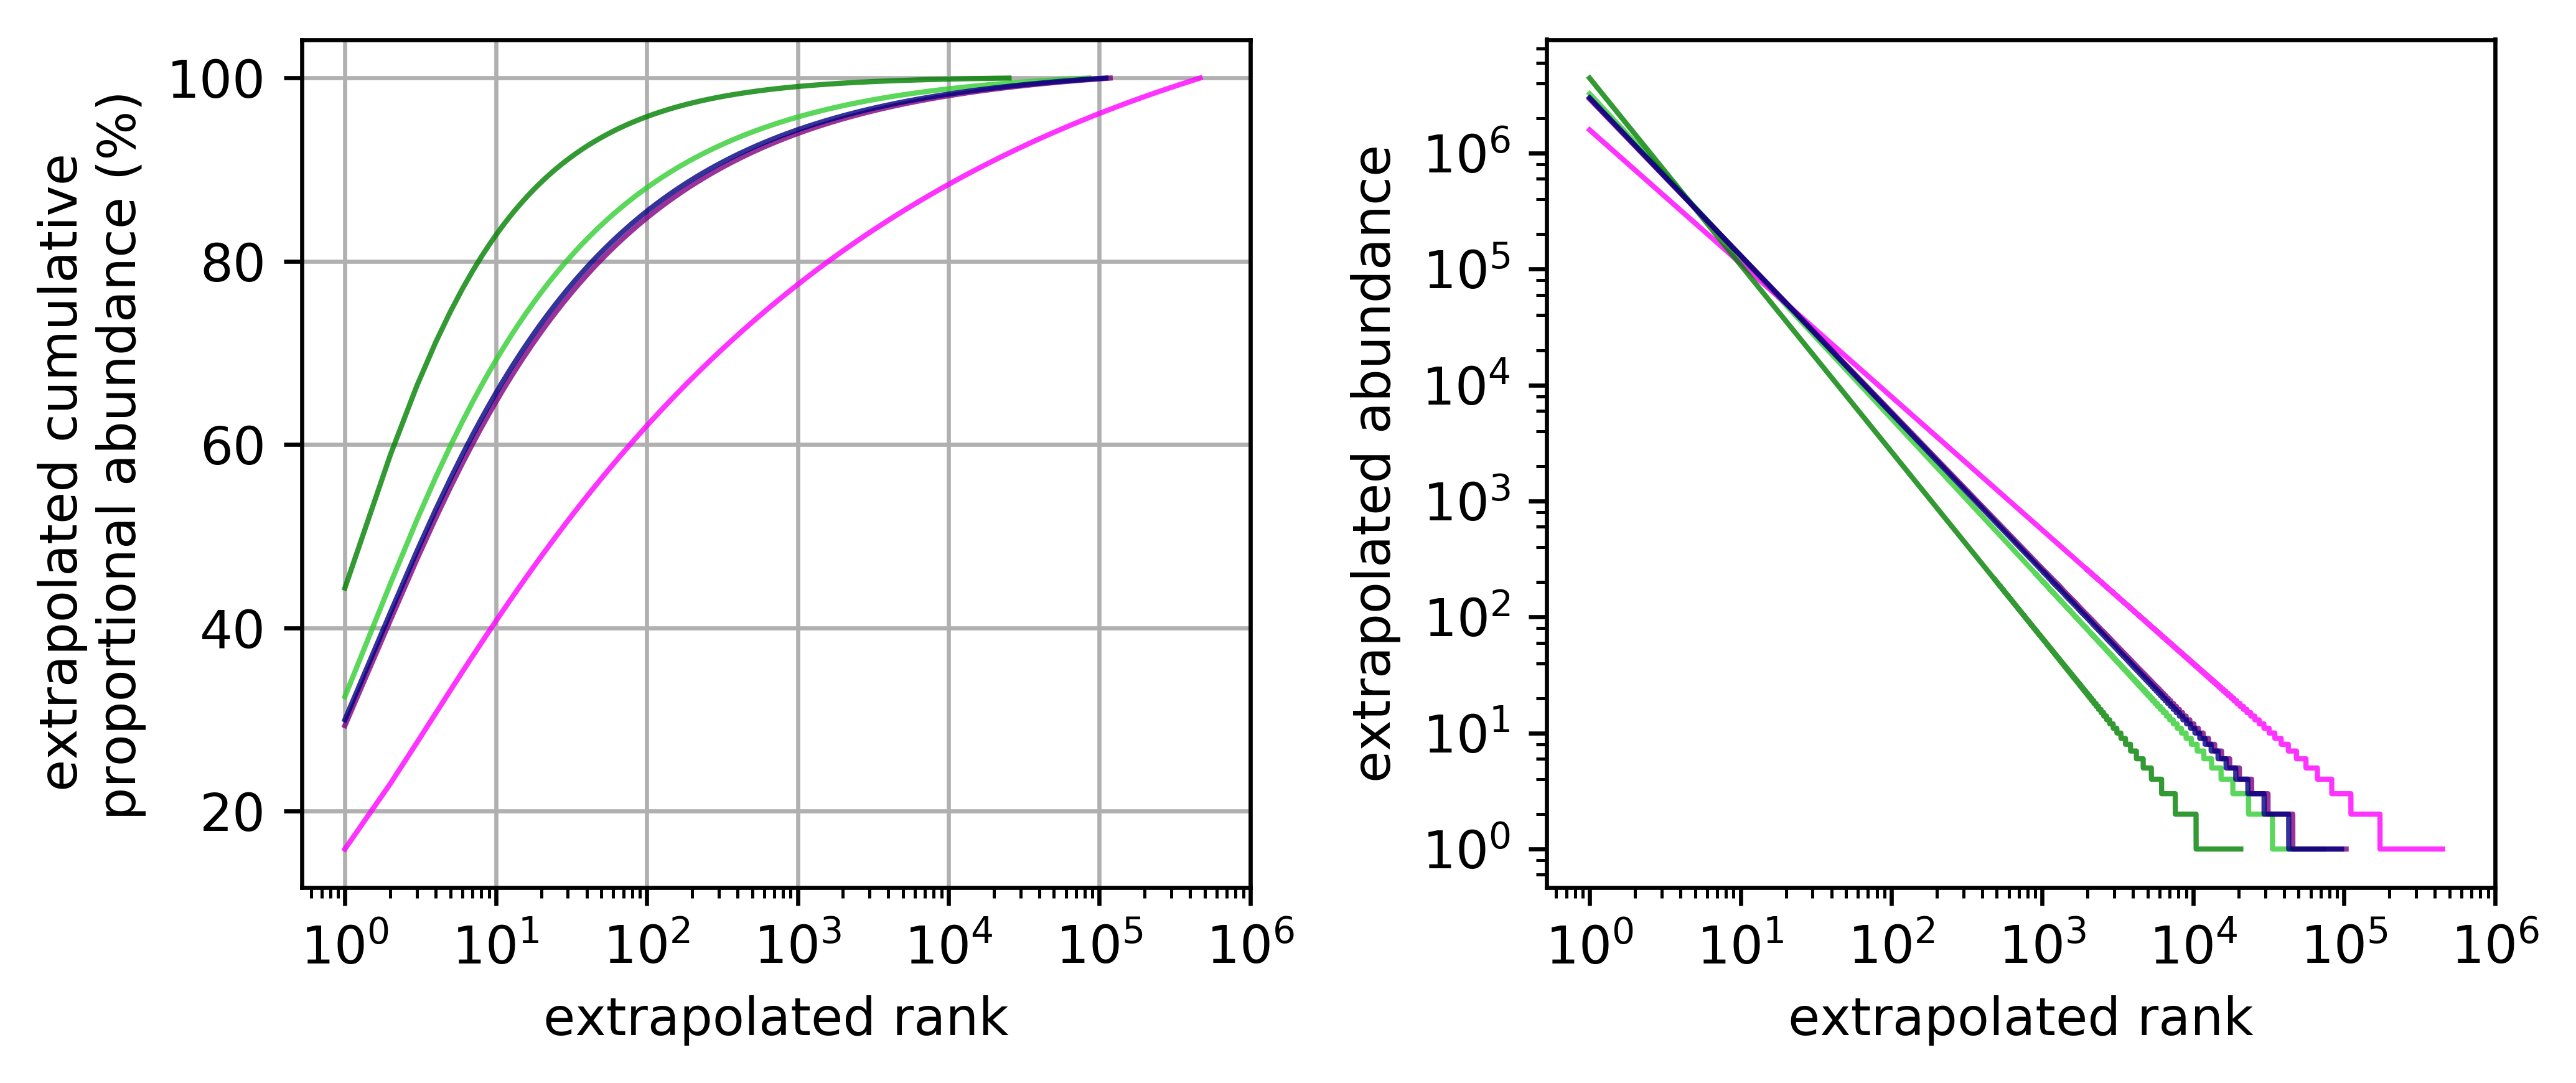

In [48]:
#extrapolate Hosmane
plt.figure(figsize=(7,3),dpi=600)

for i in range(len(ok_list)):    
    al=best_al_Hos[i]
    mr=RLH[2][i]

    r=np.arange(1,mr+1)
    a=r**(-al)
    pa=a/sum(a)
    cpa=np.cumsum(pa)
    a=np.round(L*pa)
    print(np.log10(sum(a)))
    #a=a/sum(a)*L
    
    plt.subplot(122)
    plt.loglog(r,a,color=Hcz[ok_list[i]],alpha=0.8,lw=1)

    plt.subplot(121)
    plt.semilogx(r,cpa*100,color=Hcz[ok_list[i]],alpha=0.8,lw=1)

plt.subplot(122)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated abundance')
plt.xticks(np.logspace(0,6,7))

plt.subplot(121)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated cumulative \n proportional abundance (%)')
plt.grid('on')
plt.xticks(np.logspace(0,6,7))

plt.tight_layout()
plt.savefig('figures/Hextrap.pdf')   

0
1
2
3
4


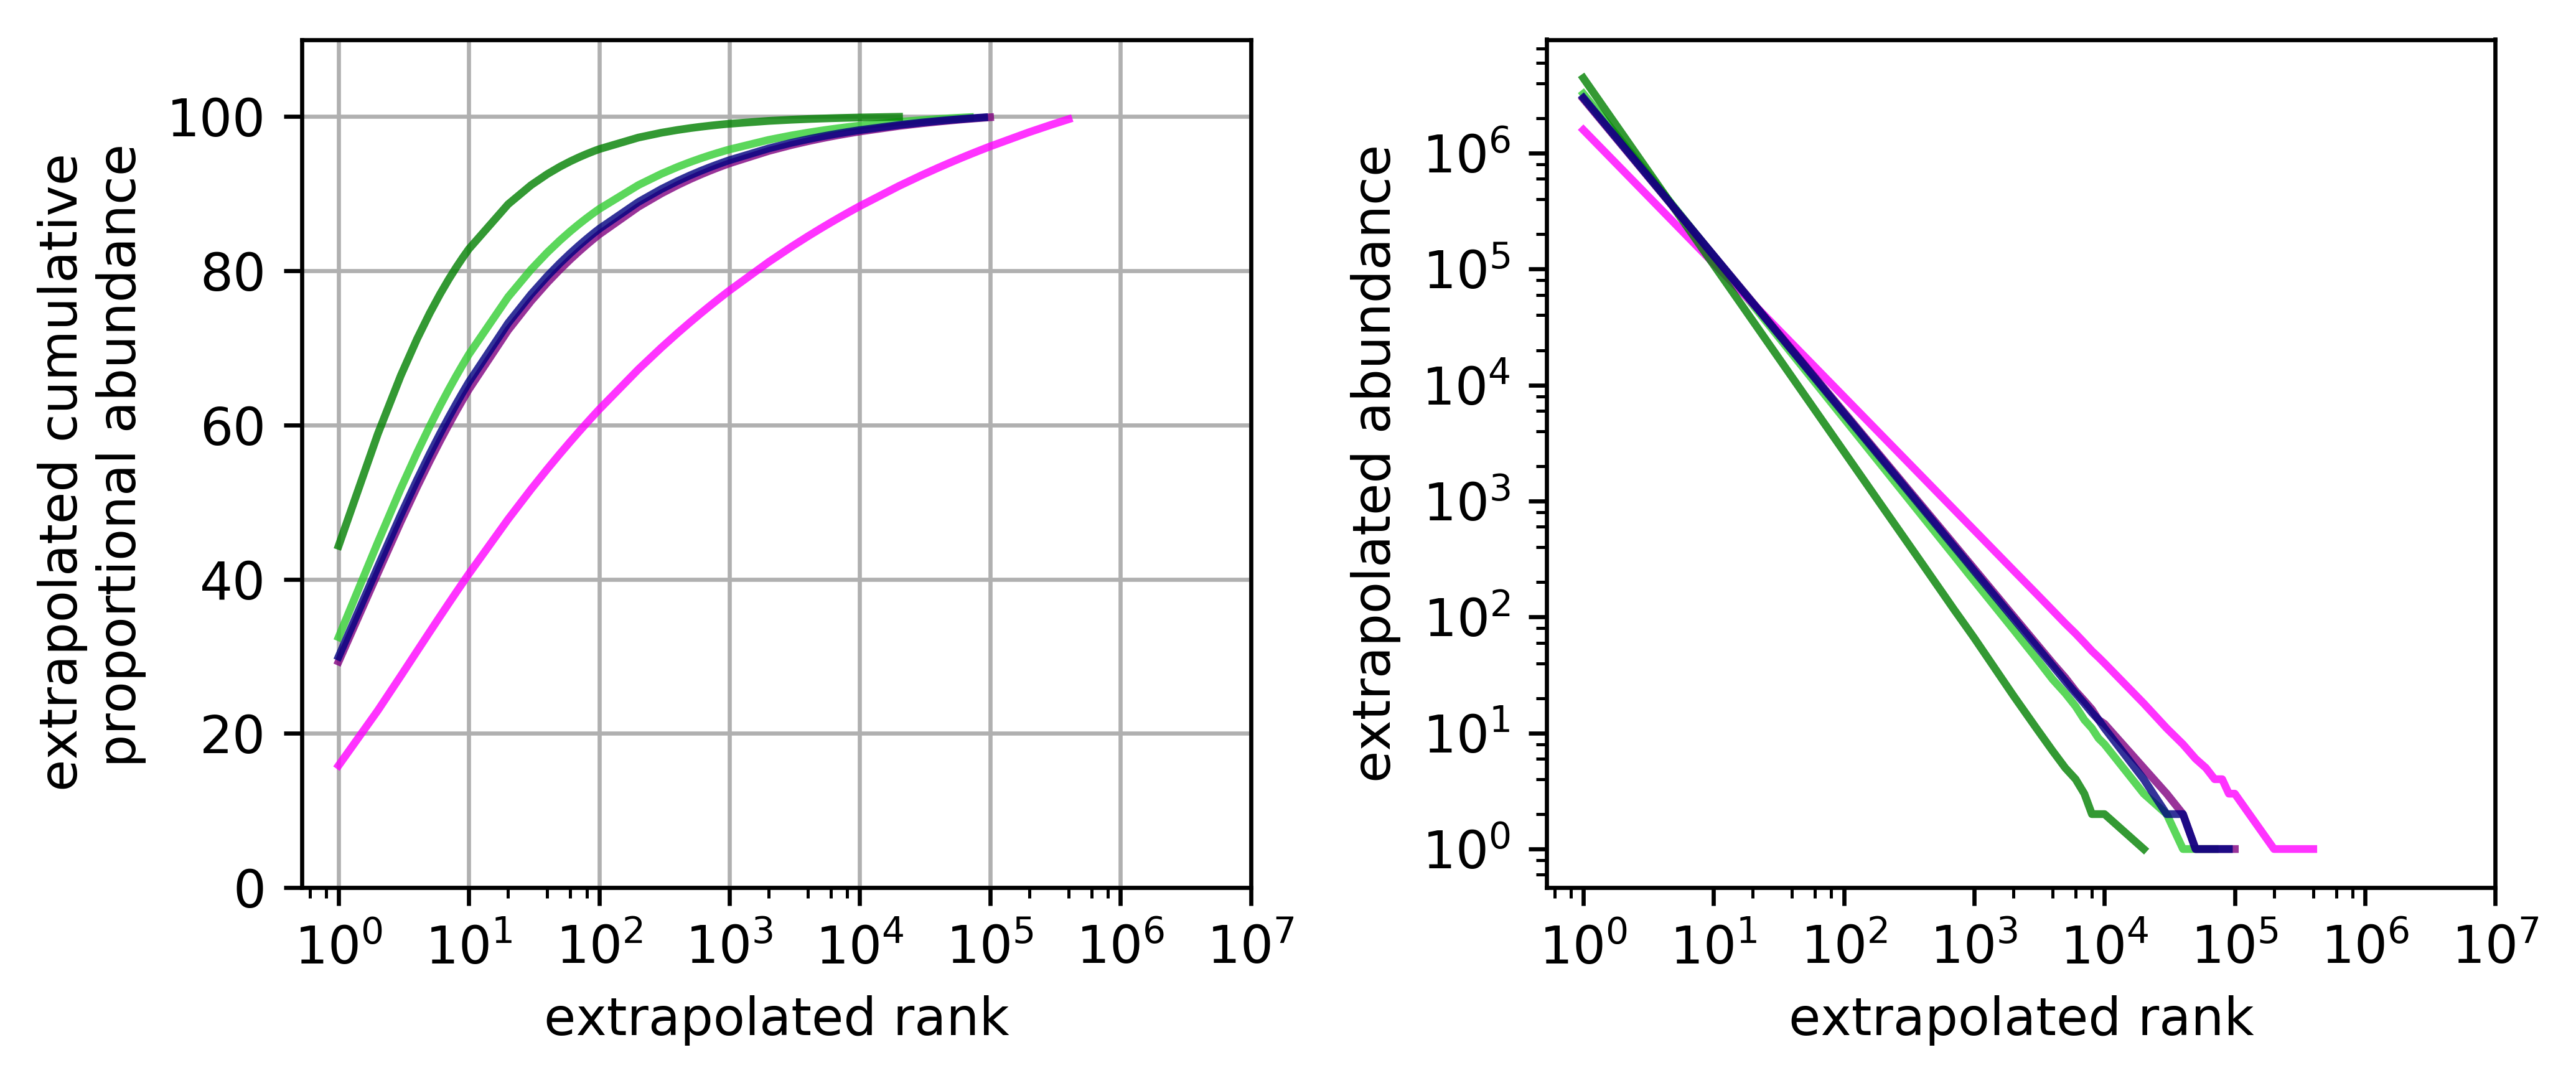

In [47]:
#extrapolate Hosmane LOOP (to check with above)
plt.figure(figsize=(7,3),dpi=600)

for i in range(len(ok_list)):    
    al=best_al_Hos[i]
    mr=RLH[2][i]
        
    #truly logarithmic list for ranks 1,2,...10,20,...,100,200,... etc
    r_ds=np.ndarray.flatten(np.tile(np.arange(1,10),[9,1])*np.transpose(np.tile(10**np.arange(0,9),[9,1])))    
    a_ds=np.zeros(len(r_ds)) #abundance downsampled
    c_ds=np.zeros(len(r_ds)) #cumulative abundance downsampled
    
    #loop over ranks, don't have to store them all
    sumz=0
    ds_int=0
    for r in np.arange(1.,mr+1.):
        a=r**(-al)
        sumz+=a
        
        #if goes past the next ds point, add to lists
        if r>r_ds[ds_int]-1:
            a_ds[ds_int]=a
            c_ds[ds_int]=sumz
            ds_int+=1
            
    pa_ds=a_ds/sumz
    
    a_ex=np.round(pa_ds*L)
    
    plt.subplot(122)
    plt.loglog(r_ds[a_ex>0],a_ex[a_ex>0],color=Hcz[ok_list[i]],alpha=0.8)

    plt.subplot(121)
    plt.semilogx(r_ds[a_ex>0],c_ds[a_ex>0]/sumz*100.,color=Hcz[ok_list[i]],alpha=0.8)

    print(i)
plt.subplot(121)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated cumulative \n proportional abundance')
plt.grid('on')
plt.xticks(np.logspace(0,7,8))
plt.ylim([0,110])

plt.subplot(122)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated abundance')
plt.xticks(np.logspace(0,7,8))

plt.tight_layout()
plt.savefig('figures/Hextrap-looptest.pdf')   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


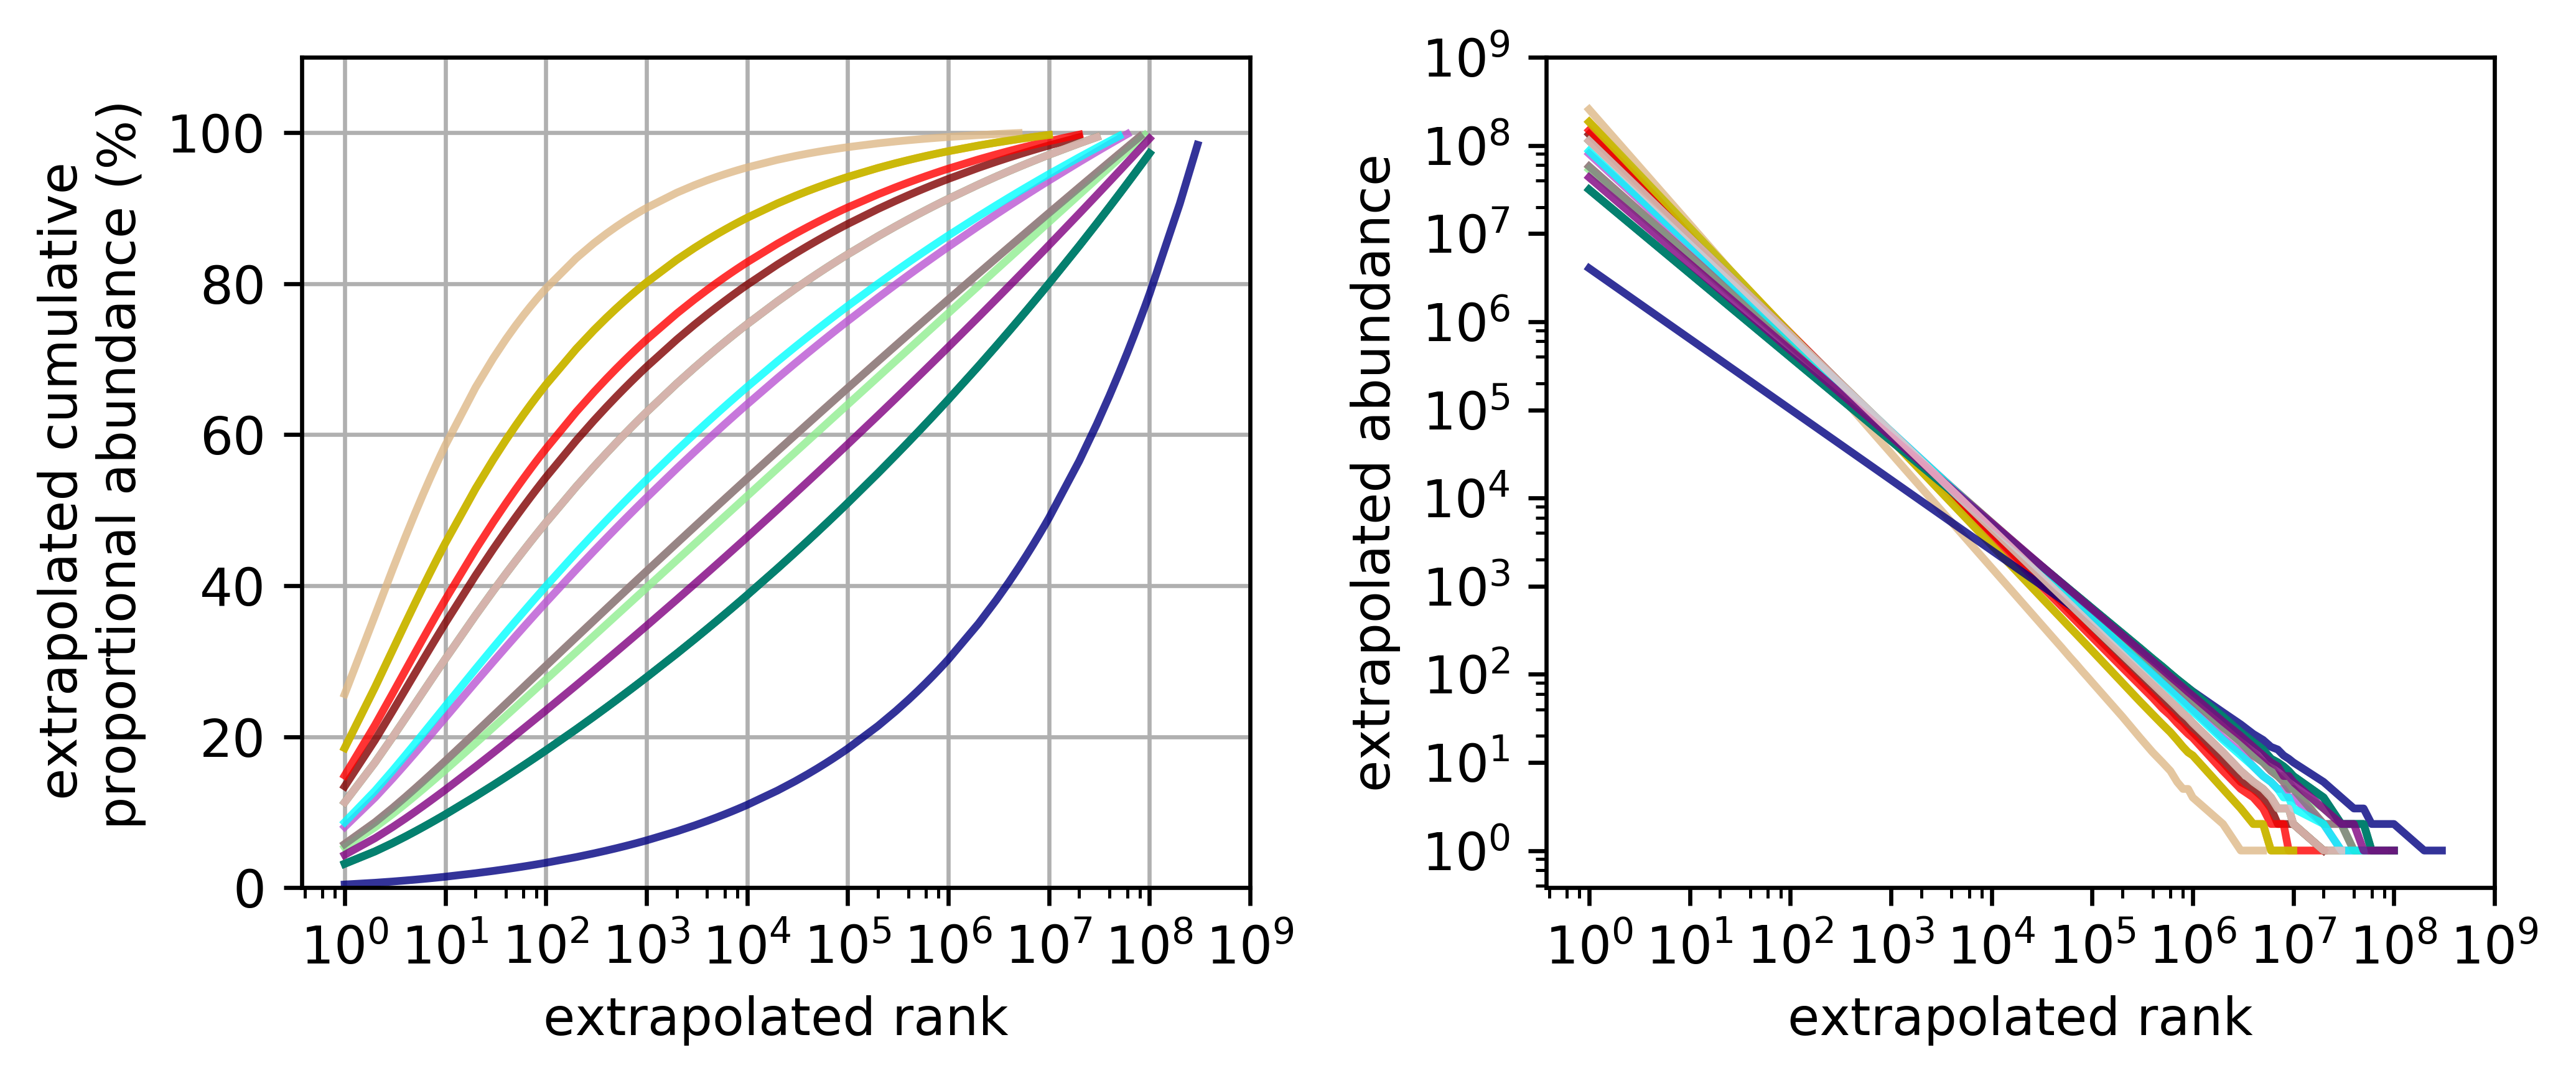

In [49]:
#extrapolate total DNA reservoir LOOP (need to loop it to do it in a reasonable time, still slow tho)
plt.figure(figsize=(7,3),dpi=600)

for i in range(len(obz)):
    al=best_al_DNA[i]
    mr=RLWM[2][i]
        
    #truly logarithmic list for ranks 1,2,...10,20,...,100,200,... etc
    r_ds=np.ndarray.flatten(np.tile(np.arange(1,10),[9,1])*np.transpose(np.tile(10**np.arange(0,9),[9,1])))    
    a_ds=np.zeros(len(r_ds)) #abundance downsampled
    c_ds=np.zeros(len(r_ds)) #cumulative abundance downsampled
    
    #loop over ranks, don't have to store them all
    sumz=0
    ds_int=0
    for r in np.arange(1.,mr+1.):
        a=r**(-al)
        sumz+=a
        
        #if goes past the next ds point, add to lists
        if r>r_ds[ds_int]-1:
            a_ds[ds_int]=a
            c_ds[ds_int]=sumz
            ds_int+=1
            
    pa_ds=a_ds/sumz
    a_ex=np.round(pa_ds*L) #the whole reservoir
    
    plt.subplot(122)
    plt.loglog(r_ds[a_ex>0],a_ex[a_ex>0],color=ob.c,alpha=0.8)

    plt.subplot(121)
    plt.semilogx(r_ds[a_ex>0],c_ds[a_ex>0]/sumz*100,color=ob.c,alpha=0.8)

    print(i)
    
plt.subplot(122)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated abundance')
plt.xticks(np.logspace(0,9,10))
plt.yticks(np.logspace(0,9,10))

plt.subplot(121)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated cumulative \n proportional abundance (%)')
plt.grid('on')
plt.xticks(np.logspace(0,9,10))
plt.ylim([0,110])

plt.tight_layout()
plt.savefig('figures/WMextrap.pdf')   

In [55]:
#compute approximation rarefaction curve based on rank and abundance data for Hosmane
al=1.2#np.mean(best_al_Hos)
mr=10**(5.5)#np.mean(RlH[2])
    
rs=np.arange(1,mr)
ab=rs**(-al)
ab=ab/sum(ab)
ab=np.round(ab*L)
ab=ab[ab>0]

R_real=len(ab)
L_real=sum(ab)

num_samples=10000 #for rarefaction

cH=range(1,num_samples+1) #cells counted
fH=np.zeros(num_samples) #found distinct
for c in cH:
    fH[c-1]=R_real-np.sum((1-ab/L_real)**c)

#do approximation rarefaction curve based on rank and abundance data for DNA
al=0.95#np.mean(best_al_DNA)
mr=1e6#np.mean(RLWM[2])

rs=np.arange(1,mr)
ab=rs**(-al)
ab=ab/sum(ab)
ab=np.round(ab*L)
ab=ab[ab>0]

R_real=len(ab)
L_real=sum(ab)

fD=np.zeros(num_samples) #found distinct
cD=range(1,num_samples+1) #cells counted
for c in cD:
    fD[c-1]=R_real-np.sum((1-ab/L_real)**c)

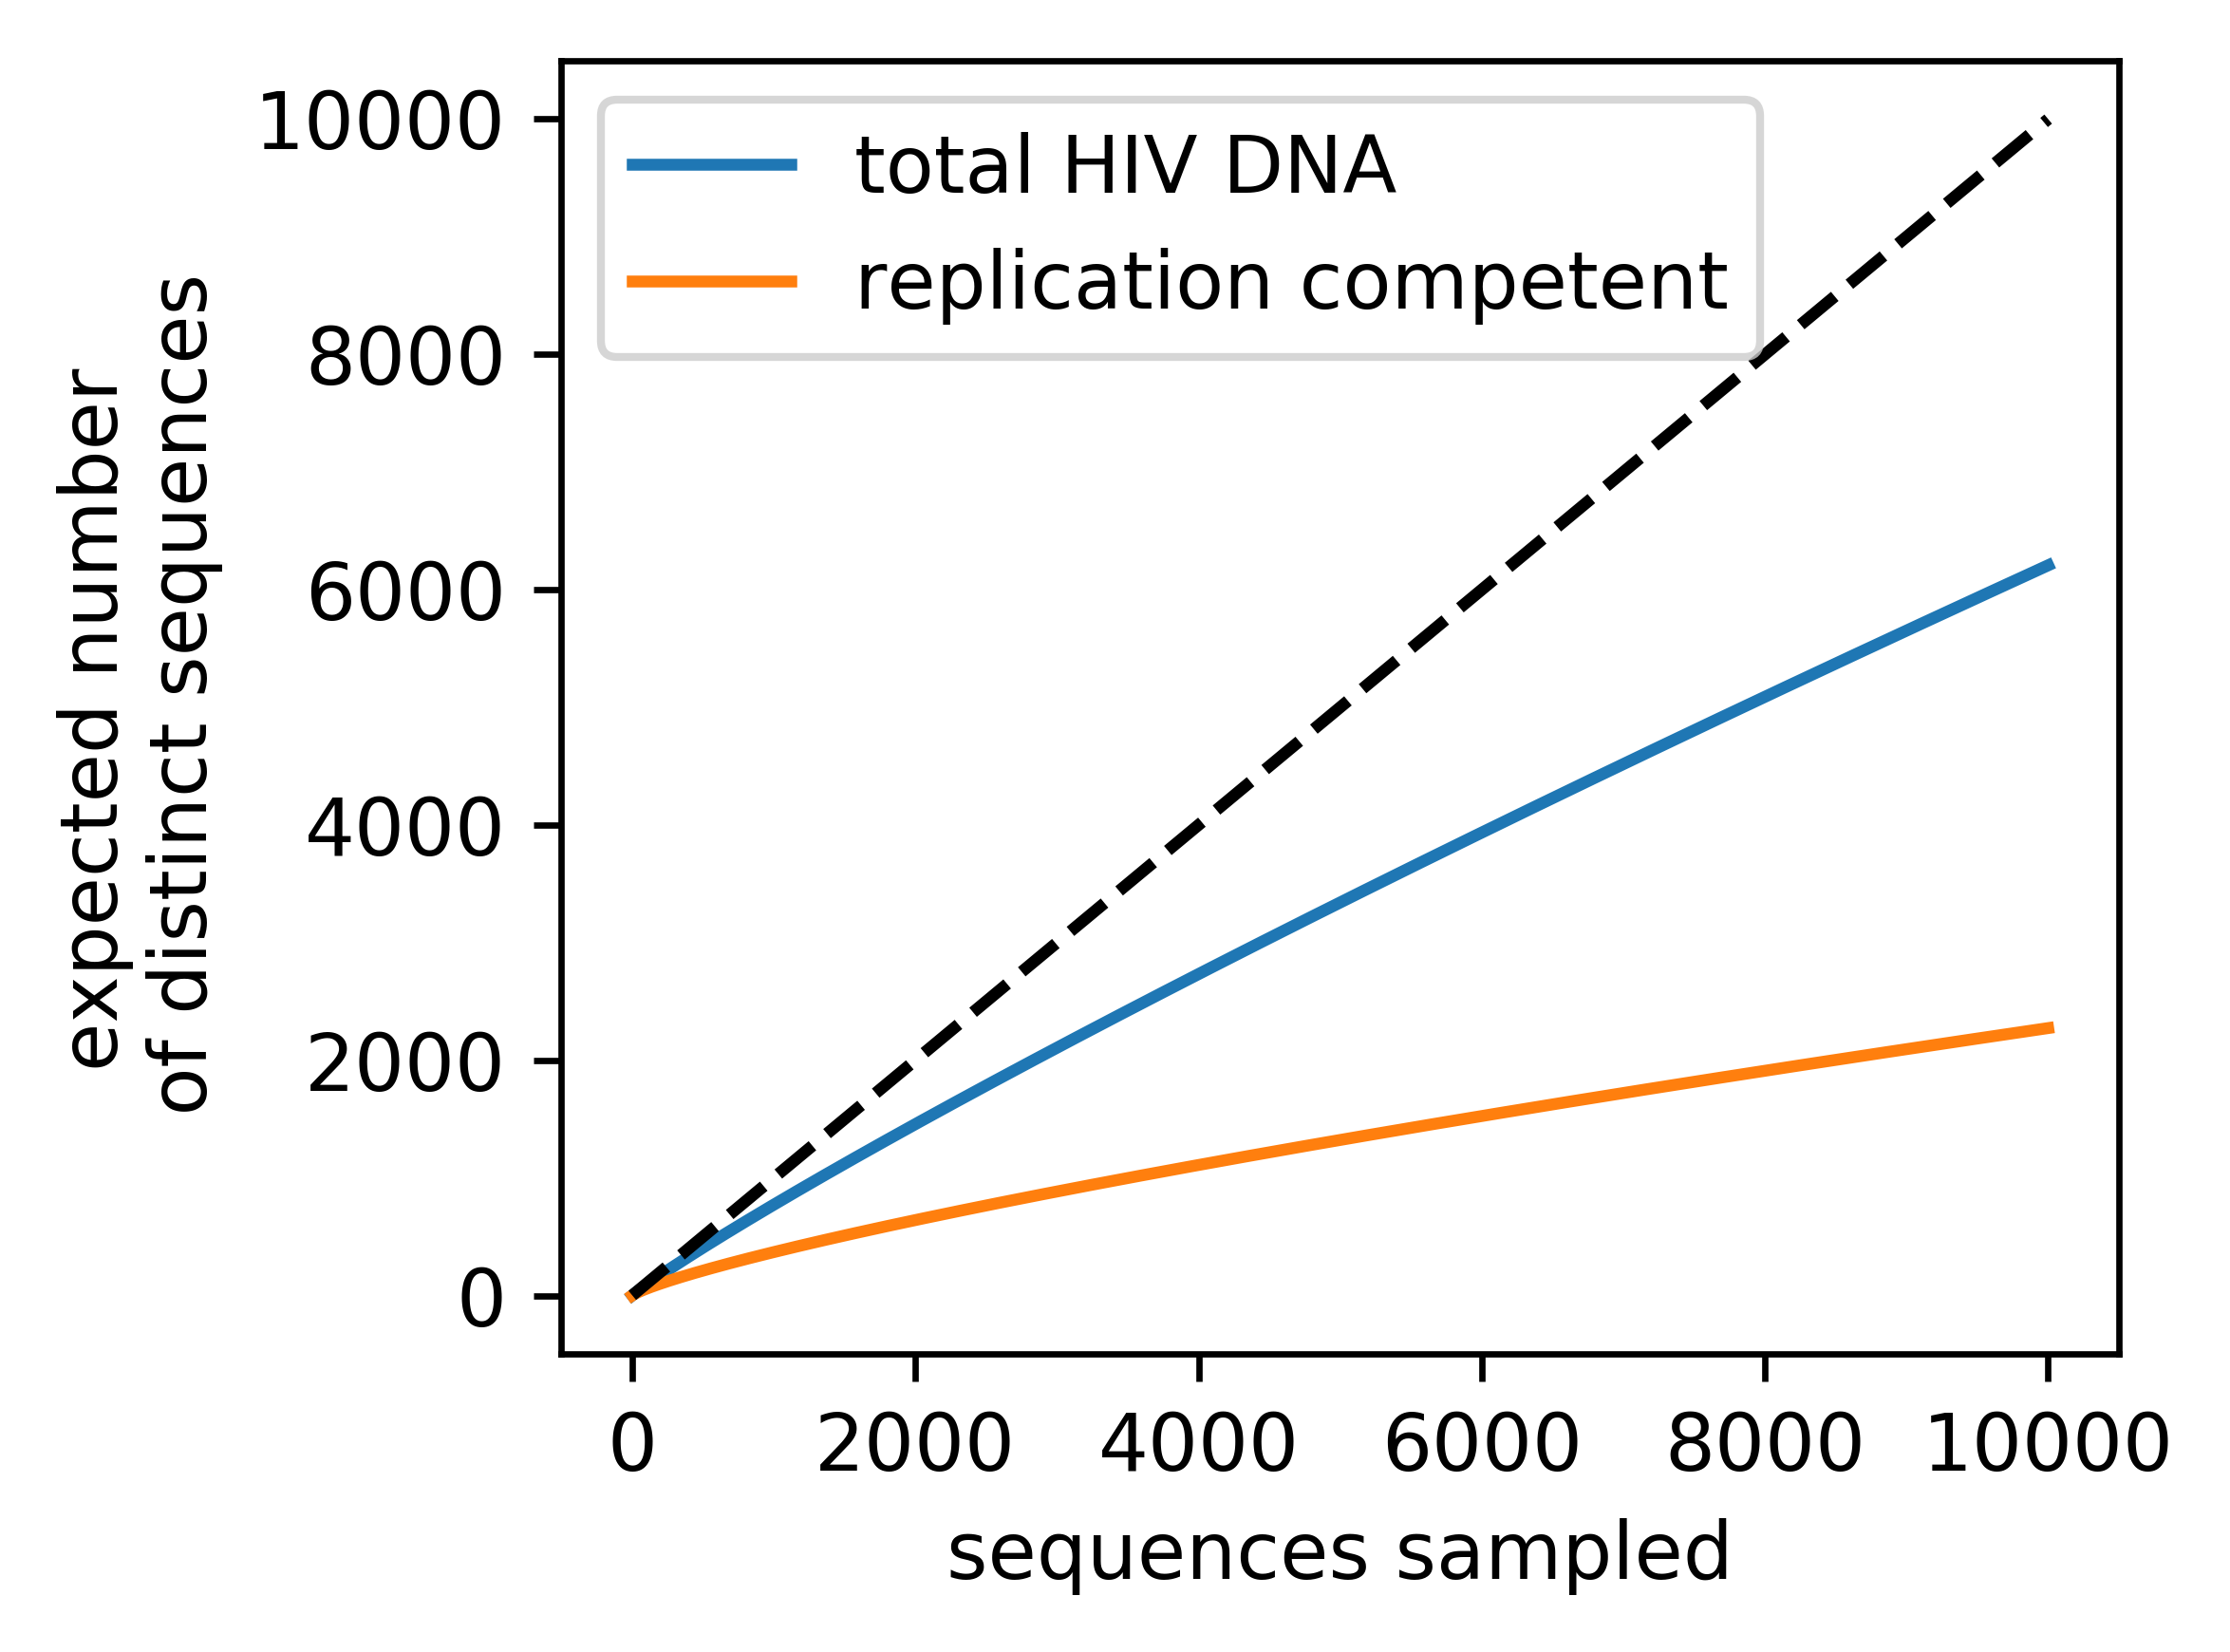

In [56]:
plt.figure(figsize=(4,3),dpi=600)
plt.plot(cD,fD)
plt.plot(cH,fH)
plt.plot(cH,cH,'--',color='k')
plt.xlabel('sequences sampled')
plt.ylabel('expected number \n of distinct sequences')
plt.legend(['total HIV DNA','replication competent'],fontsize=10)
plt.tight_layout()
plt.savefig('figures/rarefaction_extrapolated.pdf')   